<a href="https://colab.research.google.com/github/aalvarez359/3dunet-vs-medam-brain-tumor/blob/main/inference/brats2024/medsam2_infer_brat2024_brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run Scripts 1-7 for MedSAM2 BraTS2024 t2f or t2w inference

Make sure directories are set and correct modelity is selected in Script #2

#1

In [ ]:
# Cell 1: Install dependencies and clone MedSAM2
!pip install SimpleITK nibabel scikit-image --quiet

!git clone https://github.com/bowang-lab/MedSAM2.git
%cd MedSAM2

# Install MedSAM2 as an editable package
%pip install -e . --quiet

# Download MedSAM2 checkpoint
!mkdir -p checkpoints
!wget -q -P checkpoints https://huggingface.co/wanglab/MedSAM2/resolve/main/MedSAM2_2411.pt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 52.0 MB/s eta 0:00:00
Cloning into 'MedSAM2'...
remote: Enumerating objects: 297, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 297 (delta 90), reused 63 (delta 63), pack-reused 144 (from 1)
Receiving objects: 100% (297/297), 18.82 MiB | 7.77 MiB/s, done.
Resolving deltas: 100% (122/122), done.
/content/MedSAM2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.8 MB/s eta 0:00:00
  Building editable for MedSAM2 (pyproject.toml) ... done


#2

In [ ]:
# Cell 2: Mount Google Drive and define paths
from google.colab import drive
drive.mount('/content/drive')

import os, json

# ==== CHOOSE MODALITY HERE ====
# "t2f" = FLAIR-only MedSAM2
# "t2w" = T2w-only MedSAM2
MODALITY_NAME = "t2w"   # change to "t2w" for T2w MedSAM2
# ==============================

# Path to your BraTS2024 split JSON (the one created by the U-Net script)
SPLIT_JSON_PATH = "/content/drive/MyDrive/BrainTumor_Checkpoints_BraTS2024_T2F/dataset_split_brats2024.json"

# Directory where you want to save MedSAM2 segmentations
OUTPUT_ROOT = f"/content/drive/MyDrive/MedSAM2_BraTS2024_{MODALITY_NAME.upper()}_results"
os.makedirs(OUTPUT_ROOT, exist_ok=True)

# MedSAM2 config and checkpoint
MODEL_CFG = "configs/sam2.1_hiera_t512.yaml"
CHECKPOINT = "./checkpoints/MedSAM2_2411.pt"

# Load split file (has 'train', 'val', 'test')
with open(SPLIT_JSON_PATH, "r") as f:
    splits = json.load(f)

test_cases = splits["test"]   # list of dicts with keys including "case_id", MODALITY_NAME, "seg"
len(test_cases)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


271

#3

In [ ]:
# Cell 3: Helper functions for BraTS2024 single-modality + MedSAM2

import numpy as np
import nibabel as nib
import SimpleITK as sitk
import torch
from collections import OrderedDict
import matplotlib.pyplot as plt
from skimage import measure
from PIL import Image

from sam2.build_sam import build_sam2_video_predictor_npz

torch.set_float32_matmul_precision('high')
torch.manual_seed(2024)
torch.cuda.manual_seed(2024)
np.random.seed(2024)

# ---- Basic utilities ----

def getLargestCC(segmentation):
    """Keep only the largest connected component."""
    labels = measure.label(segmentation)
    if labels.max() == 0:
        return segmentation
    largestCC = labels == (np.argmax(np.bincount(labels.flat)[1:]) + 1)
    return largestCC

def show_box(box, ax, edgecolor='red'):
    """Visualize bounding box on an image."""
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle(
        (x0, y0), w, h,
        edgecolor=edgecolor,
        facecolor=(0, 0, 0, 0),
        lw=2
    ))

def show_mask(mask, ax, mask_color=None, alpha=0.5):
    """Overlay segmentation mask on image."""
    if mask_color is not None:
        color = np.concatenate([mask_color, np.array([alpha])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, alpha])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def normalize_to_uint8(volume):
    """
    Normalize a 3D volume (D, H, W) to [0, 255] uint8.
    Simple min-max normalization.
    """
    v = volume.astype(np.float32)
    v_min, v_max = np.min(v), np.max(v)
    if v_max <= v_min:
        return np.zeros_like(v, dtype=np.uint8)
    v = (v - v_min) / (v_max - v_min)
    v = (v * 255.0).clip(0, 255)
    return v.astype(np.uint8)

def resize_grayscale_to_rgb_and_resize(array, image_size):
    """
    Resize a 3D grayscale NumPy array (D, H, W) to an RGB 'video' (D, 3, image_size, image_size).
    """
    d, h, w = array.shape
    resized_array = np.zeros((d, 3, image_size, image_size), dtype=np.float32)

    for i in range(d):
        img_pil = Image.fromarray(array[i].astype(np.uint8))
        img_rgb = img_pil.convert("RGB")
        img_resized = img_rgb.resize((image_size, image_size))
        img_array = np.array(img_resized).transpose(2, 0, 1)  # (3, H, W)
        resized_array[i] = img_array

    return resized_array

# ---- BraTS2024-specific utilities ----

def load_modality_and_label(image_path, label_path):
    """
    BraTS2024 single-modality loader.

    image_path: NIfTI, shape ~ (H, W, D)
    label_path: NIfTI, shape ~ (H, W, D) with labels 0,1,2,3

    Returns:
      vol_3d : (D, H, W) single modality (t2f or t2w)
      lbl_3d : (D, H, W) label volume
      img_nii, lbl_nii : nibabel NIfTI objects (for saving with correct affine)
    """
    img_nii = nib.load(image_path)
    lbl_nii = nib.load(label_path)

    img = img_nii.get_fdata()   # (H, W, D)
    lbl = lbl_nii.get_fdata()   # (H, W, D)

    # Reorder to (D, H, W) to match your U-Net orientation
    vol_dhw = np.transpose(img, (2, 0, 1))
    lbl_dhw = np.transpose(lbl, (2, 0, 1))

    # Round labels just in case
    lbl_dhw = np.rint(lbl_dhw).astype(np.int64)

    return vol_dhw, lbl_dhw, img_nii, lbl_nii

def get_key_slice_and_bbox_from_label(lbl_3d):
    """
    Given a 3D label volume (D, H, W), choose:
      - key_slice_idx = mid-slice of the tumor in Z
      - bbox = [x_min, y_min, x_max, y_max] in that slice
    Uses all labels > 0 as 'whole tumor'.
    """
    z_idx, y_idx, x_idx = np.where(lbl_3d > 0)
    if len(z_idx) == 0:
        return None, None  # no tumor

    z_min, z_max = z_idx.min(), z_idx.max()
    key_slice_idx = int((z_min + z_max) // 2)

    slice_mask = lbl_3d[key_slice_idx] > 0
    y2, x2 = np.where(slice_mask)
    if len(y2) == 0:
        return None, None

    x_min, x_max = x2.min(), x2.max()
    y_min, y_max = y2.min(), y2.max()

    bbox = np.array([x_min, y_min, x_max, y_max], dtype=np.int32)
    return key_slice_idx, bbox

# ---- MedSAM2 predictor initialization ----

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

predictor = build_sam2_video_predictor_npz(MODEL_CFG, CHECKPOINT)


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


Using device: cuda


#4

Sample case: BraTS-GLI-03064-100
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03064-100/BraTS-GLI-03064-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03064-100/BraTS-GLI-03064-100-seg.nii.gz
Volume shape (D,H,W): (182, 182, 218)
Label  shape (D,H,W): (182, 182, 218)
key_slice_idx: 97
bbox [x_min, y_min, x_max, y_max]: [ 27  81  83 154]


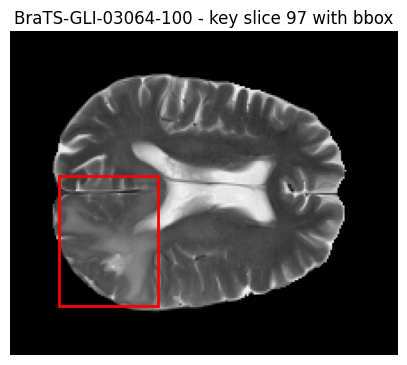

In [ ]:
# Cell 4: Preview ROI selection + key slice on one test case

from tqdm import tqdm

sample_case = test_cases[0]
image_path = sample_case[MODALITY_NAME]
label_path = sample_case["seg"]
case_id = sample_case.get("case_id", os.path.basename(image_path))

print("Sample case:", case_id)
print(" Image:", image_path)
print(" Label:", label_path)

vol_3d, lbl_3d, img_nii, lbl_nii = load_modality_and_label(image_path, label_path)
print("Volume shape (D,H,W):", vol_3d.shape)
print("Label  shape (D,H,W):", lbl_3d.shape)

key_slice_idx, bbox = get_key_slice_and_bbox_from_label(lbl_3d)
print("key_slice_idx:", key_slice_idx)
print("bbox [x_min, y_min, x_max, y_max]:", bbox)

slice_img = normalize_to_uint8(vol_3d[key_slice_idx])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(slice_img, cmap="gray")
if bbox is not None:
    show_box(bbox, ax, edgecolor="red")
ax.set_title(f"{case_id} - key slice {key_slice_idx} with bbox")
ax.axis("off")
plt.show()


#5

propagate in video: 100%|██████████| 98/98 [00:02<00:00, 38.38it/s]


Predicted mask shape: (182, 182, 218)


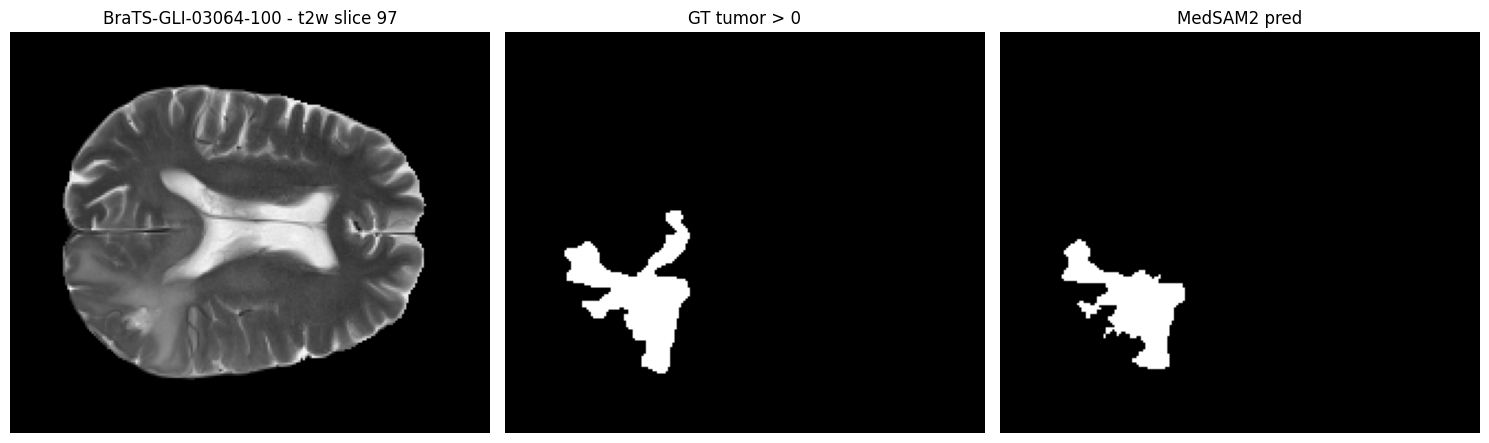

In [ ]:
# Cell 5: Function to run MedSAM2 on a single BraTS2024 volume (t2f or t2w)

def run_medsam2_on_volume(vol_3d, key_slice_idx, bbox, image_size=512):
    """
    Run MedSAM2 propagation on a 3D volume (D,H,W) for a single modality.
    Uses a single bounding box on key_slice_idx.
    Returns a 3D binary mask (D,H,W) for whole tumor.
    """
    D, H, W = vol_3d.shape
    segs_3D = np.zeros((D, H, W), dtype=np.uint8)

    # Normalize to [0,255] and ensure uint8
    vol_uint8 = normalize_to_uint8(vol_3d)

    # Resize to 512x512 for MedSAM2, but keep original H/W for mapping back
    video_height = H
    video_width  = W
    img_resized = resize_grayscale_to_rgb_and_resize(vol_uint8, image_size)  # (D, 3, 512, 512)
    img_resized = img_resized / 255.0
    img_resized = torch.from_numpy(img_resized).to(device)

    # ImageNet-style normalization (as in CT demo)
    img_mean = torch.tensor((0.485, 0.456, 0.406), dtype=torch.float32)[:, None, None].to(device)
    img_std  = torch.tensor((0.229, 0.224, 0.225), dtype=torch.float32)[:, None, None].to(device)
    img_resized = (img_resized - img_mean) / img_std

    key_slice_idx = int(key_slice_idx)

    with torch.inference_mode(), torch.autocast(
        device_type=device,
        dtype=torch.bfloat16 if device == "cuda" else torch.float16
    ):
        # Init state with full volume as a "video"
        inference_state = predictor.init_state(img_resized, video_height, video_width)

        # Forward propagation
        _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=key_slice_idx,
            obj_id=1,
            box=bbox,
        )
        for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
            mask = (out_mask_logits[0] > 0.0).detach().cpu().numpy()[0]
            segs_3D[out_frame_idx][mask] = 1

        predictor.reset_state(inference_state)

        # Reverse propagation
        _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=key_slice_idx,
            obj_id=1,
            box=bbox,
        )
        for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(
            inference_state,
            reverse=True
        ):
            mask = (out_mask_logits[0] > 0.0).detach().cpu().numpy()[0]
            segs_3D[out_frame_idx][mask] = 1

        predictor.reset_state(inference_state)

    # Keep only largest connected component (whole tumor)
    if segs_3D.max() > 0:
        segs_3D = getLargestCC(segs_3D).astype(np.uint8)

    return segs_3D

pred_3d = run_medsam2_on_volume(vol_3d, key_slice_idx, bbox)
print("Predicted mask shape:", pred_3d.shape)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(normalize_to_uint8(vol_3d[key_slice_idx]), cmap="gray")
axs[0].set_title(f"{case_id} - {MODALITY_NAME} slice {key_slice_idx}")

axs[1].imshow((lbl_3d[key_slice_idx] > 0), cmap="gray")
axs[1].set_title("GT tumor > 0")

axs[2].imshow((pred_3d[key_slice_idx] > 0), cmap="gray")
axs[2].set_title("MedSAM2 pred")

for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()


#6

In [ ]:
# Cell 6: Save MedSAM2 prediction as NIfTI with correct BraTS2024 orientation

import os
import nibabel as nib
import numpy as np

def save_pred_as_nifti(pred_3d, reference_nii, out_path):
    """
    pred_3d : (D,H,W) MedSAM2 prediction
    reference_nii : original BraTS2024 image NIfTI (img_nii)
    out_path : where to save the .nii.gz file

    We used H,W,D -> D,H,W via np.transpose(..., (2,0,1)) in the loader,
    so now we invert: (D,H,W) -> (H,W,D).
    """
    pred_hwd = np.transpose(pred_3d, (1, 2, 0))  # back to (H,W,D)

    pred_img = nib.Nifti1Image(
        pred_hwd.astype(np.uint8),
        affine=reference_nii.affine,
        header=reference_nii.header,
    )

    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    nib.save(pred_img, out_path)
    print("Saved:", out_path)

print("Cell 6 loaded successfully — save_pred_as_nifti() is ready.")


Cell 6 loaded successfully — save_pred_as_nifti() is ready.


#7

In [ ]:
# Cell 7: Run MedSAM2 (single modality) on BraTS2024 test set

from tqdm import tqdm
import pandas as pd

def dice_coefficient(pred, target, eps=1e-8):
    """
    pred, target: 3D arrays (D,H,W) with {0,1} or bool.
    Computes Dice on the whole tumor (all non-zero labels).
    """
    pred = pred.astype(bool)
    target = target.astype(bool)

    intersection = np.logical_and(pred, target).sum()
    denom = pred.sum() + target.sum()
    if denom == 0:
        return 1.0  # both empty -> perfect by convention
    return 2.0 * intersection / (denom + eps)

batch_results = []

for case in tqdm(test_cases, desc=f"MedSAM2 {MODALITY_NAME}-only on BraTS2024 test set"):
    image_path = case.get(MODALITY_NAME, None)
    label_path = case.get("seg", None)
    case_id = case.get("case_id", None)

    if image_path is None or label_path is None:
        print("Skipping (missing modality or seg) for case:", case)
        continue
    if not os.path.exists(image_path) or not os.path.exists(label_path):
        print("Skipping (files not found):", image_path)
        continue

    if case_id is None:
        case_id = os.path.basename(image_path).replace(".nii.gz", "")

    print(f"\n=== Processing case: {case_id} ===")
    print(" Image:", image_path)
    print(" Label:", label_path)

    # 1) Load modality volume + label in (D,H,W)
    vol_3d, lbl_3d, img_nii, lbl_nii = load_modality_and_label(
        image_path, label_path
    )

    # 2) Choose key slice + bbox from label (whole tumor = label > 0)
    key_slice_idx, bbox = get_key_slice_and_bbox_from_label(lbl_3d)
    if key_slice_idx is None or bbox is None:
        print(f"  -> No tumor voxels found, skipping {case_id}.")
        continue

    print("  -> key_slice_idx:", key_slice_idx)
    print("  -> bbox [x_min, y_min, x_max, y_max]:", bbox)

    # 3) Run MedSAM2 on this modality
    pred_3d = run_medsam2_on_volume(vol_3d, key_slice_idx, bbox)
    print("  -> prediction shape:", pred_3d.shape)

    # 4) Compute Dice vs GT for whole tumor (label > 0)
    gt_tumor = (lbl_3d > 0).astype(np.uint8)
    dice_whole = dice_coefficient(pred_3d, gt_tumor)
    print(f"  -> Dice (whole tumor, {MODALITY_NAME}-only): {dice_whole:.4f}")

    # 5) Save MedSAM2 mask as NIfTI in Drive
    out_mask_path = os.path.join(
        OUTPUT_ROOT,
        f"{case_id}_MedSAM2_{MODALITY_NAME.upper()}_mask.nii.gz"
    )
    save_pred_as_nifti(pred_3d, img_nii, out_mask_path)

    # 6) Record metadata & Dice for later analysis/CSV
    batch_results.append({
        "case_id": case_id,
        "modality": MODALITY_NAME,
        "image_path": image_path,
        "label_path": label_path,
        "out_mask_path": out_mask_path,
        "key_slice_idx": int(key_slice_idx),
        "bbox_xmin": int(bbox[0]),
        "bbox_ymin": int(bbox[1]),
        "bbox_xmax": int(bbox[2]),
        "bbox_ymax": int(bbox[3]),
        "dice_whole_tumor": float(dice_whole),
    })

print("\n✅ Finished MedSAM2 on all test cases.")
print("Total cases processed:", len(batch_results))

# Save a CSV summary alongside the NIfTIs
if len(batch_results) > 0:
    df = pd.DataFrame(batch_results)
    csv_path = os.path.join(OUTPUT_ROOT, f"MedSAM2_BraTS2024_{MODALITY_NAME}_test_results.csv")
    df.to_csv(csv_path, index=False)
    print("Saved results CSV:", csv_path)
else:
    print("No cases processed; no CSV saved.")


MedSAM2 t2w-only on BraTS2024 test set:   0%|          | 0/271 [00:00<?, ?it/s]


=== Processing case: BraTS-GLI-03064-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03064-100/BraTS-GLI-03064-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03064-100/BraTS-GLI-03064-100-seg.nii.gz
  -> key_slice_idx: 97
  -> bbox [x_min, y_min, x_max, y_max]: [ 27  81  83 154]



propagate in video: 100%|██████████| 85/85 [00:02<00:00, 37.85it/s]

MedSAM2 t2w-only on BraTS2024 test set:   0%|          | 1/271 [00:07<31:35,  7.02s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8438
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03064-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02514-105 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02514-105/BraTS-GLI-02514-105-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02514-105/BraTS-GLI-02514-105-seg.nii.gz
  -> key_slice_idx: 86
  -> bbox [x_min, y_min, x_max, y_max]: [ 40  33 159  85]



propagate in video: 100%|██████████| 96/96 [00:02<00:00, 37.64it/s]

MedSAM2 t2w-only on BraTS2024 test set:   1%|          | 2/271 [00:17<41:33,  9.27s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7626
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02514-105_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02170-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02170-102/BraTS-GLI-02170-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02170-102/BraTS-GLI-02170-102-seg.nii.gz
  -> key_slice_idx: 106
  -> bbox [x_min, y_min, x_max, y_max]: [ 51  31 127  80]



propagate in video: 100%|██████████| 76/76 [00:02<00:00, 37.34it/s]

propagate in video: 100%|██████████| 107/107 [00:02<00:00, 37.34it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.9338


MedSAM2 t2w-only on BraTS2024 test set:   1%|          | 3/271 [00:29<45:18, 10.14s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02170-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02105-106 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02105-106/BraTS-GLI-02105-106-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02105-106/BraTS-GLI-02105-106-seg.nii.gz
  -> key_slice_idx: 105
  -> bbox [x_min, y_min, x_max, y_max]: [52 48 98 82]



propagate in video: 100%|██████████| 77/77 [00:02<00:00, 36.76it/s]

propagate in video: 100%|██████████| 106/106 [00:02<00:00, 37.91it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8015


MedSAM2 t2w-only on BraTS2024 test set:   1%|▏         | 4/271 [00:39<46:04, 10.36s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02105-106_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02960-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02960-101/BraTS-GLI-02960-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02960-101/BraTS-GLI-02960-101-seg.nii.gz
  -> key_slice_idx: 115
  -> bbox [x_min, y_min, x_max, y_max]: [ 54  39 139  86]



propagate in video: 100%|██████████| 67/67 [00:01<00:00, 37.22it/s]

MedSAM2 t2w-only on BraTS2024 test set:   2%|▏         | 5/271 [00:50<46:18, 10.45s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8447
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02960-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02632-104 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02632-104/BraTS-GLI-02632-104-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02632-104/BraTS-GLI-02632-104-seg.nii.gz
  -> key_slice_idx: 97
  -> bbox [x_min, y_min, x_max, y_max]: [ 25  63 126 149]



propagate in video: 100%|██████████| 85/85 [00:02<00:00, 38.10it/s]

MedSAM2 t2w-only on BraTS2024 test set:   2%|▏         | 6/271 [01:00<45:38, 10.34s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7696
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02632-104_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02766-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02766-101/BraTS-GLI-02766-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02766-101/BraTS-GLI-02766-101-seg.nii.gz
  -> key_slice_idx: 87
  -> bbox [x_min, y_min, x_max, y_max]: [ 51  25 136  70]



propagate in video: 100%|██████████| 95/95 [00:02<00:00, 37.27it/s]

MedSAM2 t2w-only on BraTS2024 test set:   3%|▎         | 7/271 [01:11<46:19, 10.53s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7048
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02766-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02987-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02987-100/BraTS-GLI-02987-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02987-100/BraTS-GLI-02987-100-seg.nii.gz
  -> key_slice_idx: 106
  -> bbox [x_min, y_min, x_max, y_max]: [ 29  94 111 152]



propagate in video: 100%|██████████| 76/76 [00:02<00:00, 37.86it/s]

MedSAM2 t2w-only on BraTS2024 test set:   3%|▎         | 8/271 [01:21<46:15, 10.55s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8201
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02987-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03024-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03024-101/BraTS-GLI-03024-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03024-101/BraTS-GLI-03024-101-seg.nii.gz
  -> key_slice_idx: 122
  -> bbox [x_min, y_min, x_max, y_max]: [ 72 113 115 142]



propagate in video: 100%|██████████| 60/60 [00:01<00:00, 37.87it/s]

MedSAM2 t2w-only on BraTS2024 test set:   3%|▎         | 9/271 [01:31<45:12, 10.35s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6966
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03024-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02999-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02999-101/BraTS-GLI-02999-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02999-101/BraTS-GLI-02999-101-seg.nii.gz
  -> key_slice_idx: 110
  -> bbox [x_min, y_min, x_max, y_max]: [ 54 100 113 133]



propagate in video: 100%|██████████| 72/72 [00:01<00:00, 37.48it/s]

MedSAM2 t2w-only on BraTS2024 test set:   4%|▎         | 10/271 [01:42<45:23, 10.44s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8503
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02999-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02932-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02932-100/BraTS-GLI-02932-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02932-100/BraTS-GLI-02932-100-seg.nii.gz
  -> key_slice_idx: 100
  -> bbox [x_min, y_min, x_max, y_max]: [36 38 70 73]



propagate in video: 100%|██████████| 82/82 [00:02<00:00, 36.31it/s]

MedSAM2 t2w-only on BraTS2024 test set:   4%|▍         | 11/271 [01:52<44:51, 10.35s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5974
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02932-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02072-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02072-103/BraTS-GLI-02072-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02072-103/BraTS-GLI-02072-103-seg.nii.gz
  -> key_slice_idx: 90
  -> bbox [x_min, y_min, x_max, y_max]: [ 75  29 140  79]



propagate in video: 100%|██████████| 92/92 [00:02<00:00, 36.99it/s]

propagate in video: 100%|██████████| 91/91 [00:02<00:00, 36.40it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8845


MedSAM2 t2w-only on BraTS2024 test set:   4%|▍         | 12/271 [02:03<45:09, 10.46s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02072-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02221-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02221-100/BraTS-GLI-02221-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02221-100/BraTS-GLI-02221-100-seg.nii.gz
  -> key_slice_idx: 104
  -> bbox [x_min, y_min, x_max, y_max]: [ 45  34 137 116]



propagate in video: 100%|██████████| 78/78 [00:02<00:00, 37.39it/s]

MedSAM2 t2w-only on BraTS2024 test set:   5%|▍         | 13/271 [02:13<45:05, 10.49s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.9005
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02221-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02846-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02846-100/BraTS-GLI-02846-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02846-100/BraTS-GLI-02846-100-seg.nii.gz
  -> key_slice_idx: 93
  -> bbox [x_min, y_min, x_max, y_max]: [ 38  46 187 140]



propagate in video: 100%|██████████| 89/89 [00:02<00:00, 37.25it/s]

MedSAM2 t2w-only on BraTS2024 test set:   5%|▌         | 14/271 [02:24<44:41, 10.44s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8181
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02846-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02199-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02199-100/BraTS-GLI-02199-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02199-100/BraTS-GLI-02199-100-seg.nii.gz
  -> key_slice_idx: 92
  -> bbox [x_min, y_min, x_max, y_max]: [146  73 186 121]



propagate in video: 100%|██████████| 90/90 [00:02<00:00, 37.38it/s]

MedSAM2 t2w-only on BraTS2024 test set:   6%|▌         | 15/271 [02:35<45:19, 10.62s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7617
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02199-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02111-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02111-101/BraTS-GLI-02111-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02111-101/BraTS-GLI-02111-101-seg.nii.gz
  -> key_slice_idx: 117
  -> bbox [x_min, y_min, x_max, y_max]: [51 61 99 85]



propagate in video: 100%|██████████| 65/65 [00:01<00:00, 36.45it/s]

propagate in video: 100%|██████████| 118/118 [00:03<00:00, 36.79it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5855


MedSAM2 t2w-only on BraTS2024 test set:   6%|▌         | 16/271 [02:47<46:31, 10.95s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02111-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02362-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02362-100/BraTS-GLI-02362-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02362-100/BraTS-GLI-02362-100-seg.nii.gz
  -> key_slice_idx: 74
  -> bbox [x_min, y_min, x_max, y_max]: [ 60 110 160 154]



propagate in video: 100%|██████████| 108/108 [00:02<00:00, 36.95it/s]

propagate in video: 100%|██████████| 75/75 [00:02<00:00, 36.91it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8873


MedSAM2 t2w-only on BraTS2024 test set:   6%|▋         | 17/271 [02:57<46:00, 10.87s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02362-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02087-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02087-101/BraTS-GLI-02087-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02087-101/BraTS-GLI-02087-101-seg.nii.gz
  -> key_slice_idx: 115
  -> bbox [x_min, y_min, x_max, y_max]: [ 55  37 140 113]



propagate in video: 100%|██████████| 67/67 [00:01<00:00, 36.97it/s]

propagate in video: 100%|██████████| 116/116 [00:03<00:00, 36.69it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8696


MedSAM2 t2w-only on BraTS2024 test set:   7%|▋         | 18/271 [03:09<47:05, 11.17s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02087-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02199-104 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02199-104/BraTS-GLI-02199-104-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02199-104/BraTS-GLI-02199-104-seg.nii.gz
  -> key_slice_idx: 100
  -> bbox [x_min, y_min, x_max, y_max]: [140  73 183 122]



propagate in video: 100%|██████████| 82/82 [00:02<00:00, 36.93it/s]

MedSAM2 t2w-only on BraTS2024 test set:   7%|▋         | 19/271 [03:19<45:37, 10.86s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7429
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02199-104_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02114-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02114-100/BraTS-GLI-02114-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02114-100/BraTS-GLI-02114-100-seg.nii.gz
  -> key_slice_idx: 103
  -> bbox [x_min, y_min, x_max, y_max]: [ 65  60 185 146]



propagate in video: 100%|██████████| 79/79 [00:02<00:00, 37.11it/s]

propagate in video: 100%|██████████| 104/104 [00:02<00:00, 37.10it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6379


MedSAM2 t2w-only on BraTS2024 test set:   7%|▋         | 20/271 [03:30<45:22, 10.85s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02114-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02820-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02820-100/BraTS-GLI-02820-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02820-100/BraTS-GLI-02820-100-seg.nii.gz
  -> key_slice_idx: 122
  -> bbox [x_min, y_min, x_max, y_max]: [105  47 175  97]



propagate in video: 100%|██████████| 60/60 [00:01<00:00, 37.79it/s]

MedSAM2 t2w-only on BraTS2024 test set:   8%|▊         | 21/271 [03:40<44:13, 10.62s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8819
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02820-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03050-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03050-100/BraTS-GLI-03050-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03050-100/BraTS-GLI-03050-100-seg.nii.gz
  -> key_slice_idx: 107
  -> bbox [x_min, y_min, x_max, y_max]: [ 32  93 105 137]



propagate in video: 100%|██████████| 75/75 [00:02<00:00, 37.29it/s]

MedSAM2 t2w-only on BraTS2024 test set:   8%|▊         | 22/271 [03:50<43:18, 10.43s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.9038
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03050-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02498-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02498-101/BraTS-GLI-02498-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02498-101/BraTS-GLI-02498-101-seg.nii.gz
  -> key_slice_idx: 121
  -> bbox [x_min, y_min, x_max, y_max]: [ 92  92 142 125]



propagate in video: 100%|██████████| 61/61 [00:01<00:00, 37.44it/s]

MedSAM2 t2w-only on BraTS2024 test set:   8%|▊         | 23/271 [04:01<43:24, 10.50s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7701
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02498-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02086-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02086-100/BraTS-GLI-02086-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02086-100/BraTS-GLI-02086-100-seg.nii.gz
  -> key_slice_idx: 115
  -> bbox [x_min, y_min, x_max, y_max]: [ 55 106 129 152]



propagate in video: 100%|██████████| 67/67 [00:01<00:00, 37.73it/s]

propagate in video: 100%|██████████| 116/116 [00:03<00:00, 37.53it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8365


MedSAM2 t2w-only on BraTS2024 test set:   9%|▉         | 24/271 [04:13<45:27, 11.04s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02086-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02092-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02092-103/BraTS-GLI-02092-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02092-103/BraTS-GLI-02092-103-seg.nii.gz
  -> key_slice_idx: 98
  -> bbox [x_min, y_min, x_max, y_max]: [132  59 188 122]



propagate in video: 100%|██████████| 84/84 [00:02<00:00, 37.44it/s]

propagate in video: 100%|██████████| 99/99 [00:02<00:00, 37.72it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8179


MedSAM2 t2w-only on BraTS2024 test set:   9%|▉         | 25/271 [04:25<46:24, 11.32s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02092-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02781-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02781-100/BraTS-GLI-02781-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02781-100/BraTS-GLI-02781-100-seg.nii.gz
  -> key_slice_idx: 124
  -> bbox [x_min, y_min, x_max, y_max]: [ 62  46 145  80]



propagate in video: 100%|██████████| 58/58 [00:01<00:00, 38.28it/s]

MedSAM2 t2w-only on BraTS2024 test set:  10%|▉         | 26/271 [04:37<46:50, 11.47s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5804
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02781-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02063-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02063-100/BraTS-GLI-02063-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02063-100/BraTS-GLI-02063-100-seg.nii.gz
  -> key_slice_idx: 114
  -> bbox [x_min, y_min, x_max, y_max]: [ 66  27 138  77]



propagate in video: 100%|██████████| 68/68 [00:01<00:00, 38.05it/s]

propagate in video: 100%|██████████| 115/115 [00:03<00:00, 37.08it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.9094


MedSAM2 t2w-only on BraTS2024 test set:  10%|▉         | 27/271 [04:47<45:29, 11.19s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02063-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02756-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02756-100/BraTS-GLI-02756-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02756-100/BraTS-GLI-02756-100-seg.nii.gz
  -> key_slice_idx: 94
  -> bbox [x_min, y_min, x_max, y_max]: [ 82  36 158  69]



propagate in video: 100%|██████████| 88/88 [00:02<00:00, 37.95it/s]

MedSAM2 t2w-only on BraTS2024 test set:  10%|█         | 28/271 [04:58<44:47, 11.06s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.3009
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02756-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00060-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00060-101/BraTS-GLI-00060-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00060-101/BraTS-GLI-00060-101-seg.nii.gz
  -> key_slice_idx: 75
  -> bbox [x_min, y_min, x_max, y_max]: [156  65 162 108]



propagate in video: 100%|██████████| 107/107 [00:02<00:00, 37.80it/s]

MedSAM2 t2w-only on BraTS2024 test set:  11%|█         | 29/271 [05:10<45:24, 11.26s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.4403
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00060-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02997-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02997-101/BraTS-GLI-02997-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02997-101/BraTS-GLI-02997-101-seg.nii.gz
  -> key_slice_idx: 88
  -> bbox [x_min, y_min, x_max, y_max]: [ 45  40 159  87]



propagate in video: 100%|██████████| 94/94 [00:02<00:00, 37.66it/s]

MedSAM2 t2w-only on BraTS2024 test set:  11%|█         | 30/271 [05:21<45:35, 11.35s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8645
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02997-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00557-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00557-100/BraTS-GLI-00557-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00557-100/BraTS-GLI-00557-100-seg.nii.gz
  -> key_slice_idx: 105
  -> bbox [x_min, y_min, x_max, y_max]: [ 61  39 149  81]



propagate in video: 100%|██████████| 77/77 [00:02<00:00, 37.11it/s]

MedSAM2 t2w-only on BraTS2024 test set:  11%|█▏        | 31/271 [05:31<43:40, 10.92s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8280
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00557-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02847-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02847-101/BraTS-GLI-02847-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02847-101/BraTS-GLI-02847-101-seg.nii.gz
  -> key_slice_idx: 122
  -> bbox [x_min, y_min, x_max, y_max]: [ 82 101 149 130]



propagate in video: 100%|██████████| 60/60 [00:01<00:00, 37.28it/s]

MedSAM2 t2w-only on BraTS2024 test set:  12%|█▏        | 32/271 [05:42<42:59, 10.79s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6651
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02847-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02172-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02172-100/BraTS-GLI-02172-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02172-100/BraTS-GLI-02172-100-seg.nii.gz
  -> key_slice_idx: 74
  -> bbox [x_min, y_min, x_max, y_max]: [ 75  29 126  51]



propagate in video: 100%|██████████| 108/108 [00:02<00:00, 36.85it/s]

propagate in video: 100%|██████████| 75/75 [00:02<00:00, 37.49it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.3506


MedSAM2 t2w-only on BraTS2024 test set:  12%|█▏        | 33/271 [05:54<43:56, 11.08s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02172-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02930-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02930-101/BraTS-GLI-02930-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02930-101/BraTS-GLI-02930-101-seg.nii.gz
  -> key_slice_idx: 90
  -> bbox [x_min, y_min, x_max, y_max]: [ 43  52 147 127]



propagate in video: 100%|██████████| 92/92 [00:02<00:00, 37.18it/s]

MedSAM2 t2w-only on BraTS2024 test set:  13%|█▎        | 34/271 [06:04<42:23, 10.73s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7338
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02930-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02860-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02860-100/BraTS-GLI-02860-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02860-100/BraTS-GLI-02860-100-seg.nii.gz
  -> key_slice_idx: 96
  -> bbox [x_min, y_min, x_max, y_max]: [116  44 167  83]



propagate in video: 100%|██████████| 86/86 [00:02<00:00, 38.02it/s]

MedSAM2 t2w-only on BraTS2024 test set:  13%|█▎        | 35/271 [06:14<42:27, 10.79s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8909
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02860-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00009-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00009-101/BraTS-GLI-00009-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00009-101/BraTS-GLI-00009-101-seg.nii.gz
  -> key_slice_idx: 92
  -> bbox [x_min, y_min, x_max, y_max]: [109  87 177 131]



propagate in video: 100%|██████████| 90/90 [00:02<00:00, 37.12it/s]

MedSAM2 t2w-only on BraTS2024 test set:  13%|█▎        | 36/271 [06:24<41:15, 10.53s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8001
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00009-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02888-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02888-100/BraTS-GLI-02888-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02888-100/BraTS-GLI-02888-100-seg.nii.gz
  -> key_slice_idx: 94
  -> bbox [x_min, y_min, x_max, y_max]: [ 71  63 160 134]



propagate in video: 100%|██████████| 88/88 [00:02<00:00, 36.99it/s]

MedSAM2 t2w-only on BraTS2024 test set:  14%|█▎        | 37/271 [06:35<41:19, 10.60s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7140
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02888-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02907-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02907-100/BraTS-GLI-02907-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02907-100/BraTS-GLI-02907-100-seg.nii.gz
  -> key_slice_idx: 107
  -> bbox [x_min, y_min, x_max, y_max]: [ 59  25 145  87]



propagate in video: 100%|██████████| 75/75 [00:02<00:00, 37.44it/s]

MedSAM2 t2w-only on BraTS2024 test set:  14%|█▍        | 38/271 [06:46<41:07, 10.59s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7939
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02907-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02169-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02169-100/BraTS-GLI-02169-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02169-100/BraTS-GLI-02169-100-seg.nii.gz
  -> key_slice_idx: 88
  -> bbox [x_min, y_min, x_max, y_max]: [ 43 100 130 150]



propagate in video: 100%|██████████| 94/94 [00:02<00:00, 37.31it/s]

propagate in video: 100%|██████████| 89/89 [00:02<00:00, 38.15it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.9314


MedSAM2 t2w-only on BraTS2024 test set:  14%|█▍        | 39/271 [06:58<42:36, 11.02s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02169-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02062-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02062-101/BraTS-GLI-02062-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02062-101/BraTS-GLI-02062-101-seg.nii.gz
  -> key_slice_idx: 91
  -> bbox [x_min, y_min, x_max, y_max]: [ 43  30 110  73]



propagate in video: 100%|██████████| 91/91 [00:02<00:00, 37.40it/s]

propagate in video: 100%|██████████| 92/92 [00:02<00:00, 37.39it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6421


MedSAM2 t2w-only on BraTS2024 test set:  15%|█▍        | 40/271 [07:08<42:04, 10.93s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02062-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02553-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02553-101/BraTS-GLI-02553-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02553-101/BraTS-GLI-02553-101-seg.nii.gz
  -> key_slice_idx: 90
  -> bbox [x_min, y_min, x_max, y_max]: [28 36 88 87]



propagate in video: 100%|██████████| 92/92 [00:02<00:00, 37.49it/s]

MedSAM2 t2w-only on BraTS2024 test set:  15%|█▌        | 41/271 [07:19<41:34, 10.85s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8059
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02553-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03000-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03000-100/BraTS-GLI-03000-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03000-100/BraTS-GLI-03000-100-seg.nii.gz
  -> key_slice_idx: 101
  -> bbox [x_min, y_min, x_max, y_max]: [ 83  55 177 126]



propagate in video: 100%|██████████| 81/81 [00:02<00:00, 37.63it/s]

MedSAM2 t2w-only on BraTS2024 test set:  15%|█▌        | 42/271 [07:29<40:14, 10.54s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8641
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03000-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02146-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02146-100/BraTS-GLI-02146-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02146-100/BraTS-GLI-02146-100-seg.nii.gz
  -> key_slice_idx: 88
  -> bbox [x_min, y_min, x_max, y_max]: [ 45  50  80 123]



propagate in video: 100%|██████████| 94/94 [00:02<00:00, 37.32it/s]

propagate in video: 100%|██████████| 89/89 [00:02<00:00, 37.52it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.4175


MedSAM2 t2w-only on BraTS2024 test set:  16%|█▌        | 43/271 [07:40<40:14, 10.59s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02146-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02707-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02707-100/BraTS-GLI-02707-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02707-100/BraTS-GLI-02707-100-seg.nii.gz
  -> key_slice_idx: 101
  -> bbox [x_min, y_min, x_max, y_max]: [ 60  23 149  78]



propagate in video: 100%|██████████| 81/81 [00:02<00:00, 37.63it/s]

MedSAM2 t2w-only on BraTS2024 test set:  16%|█▌        | 44/271 [07:50<39:25, 10.42s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8906
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02707-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00506-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00506-100/BraTS-GLI-00506-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00506-100/BraTS-GLI-00506-100-seg.nii.gz
  -> key_slice_idx: 121
  -> bbox [x_min, y_min, x_max, y_max]: [ 38  48 101  91]



propagate in video: 100%|██████████| 61/61 [00:01<00:00, 37.92it/s]

MedSAM2 t2w-only on BraTS2024 test set:  17%|█▋        | 45/271 [07:59<38:23, 10.19s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8448
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00506-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02123-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02123-103/BraTS-GLI-02123-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02123-103/BraTS-GLI-02123-103-seg.nii.gz
  -> key_slice_idx: 76
  -> bbox [x_min, y_min, x_max, y_max]: [ 45  63  85 114]



propagate in video: 100%|██████████| 106/106 [00:02<00:00, 37.72it/s]

propagate in video: 100%|██████████| 77/77 [00:02<00:00, 37.55it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6102


MedSAM2 t2w-only on BraTS2024 test set:  17%|█▋        | 46/271 [08:10<38:23, 10.24s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02123-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02167-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02167-101/BraTS-GLI-02167-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02167-101/BraTS-GLI-02167-101-seg.nii.gz
  -> key_slice_idx: 81
  -> bbox [x_min, y_min, x_max, y_max]: [ 57  24 155  78]



propagate in video: 100%|██████████| 101/101 [00:02<00:00, 37.28it/s]

propagate in video: 100%|██████████| 82/82 [00:02<00:00, 37.73it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5364


MedSAM2 t2w-only on BraTS2024 test set:  17%|█▋        | 47/271 [08:22<40:48, 10.93s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02167-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02315-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02315-100/BraTS-GLI-02315-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02315-100/BraTS-GLI-02315-100-seg.nii.gz
  -> key_slice_idx: 63
  -> bbox [x_min, y_min, x_max, y_max]: [ 27  28 104 118]



propagate in video: 100%|██████████| 119/119 [00:03<00:00, 36.66it/s]

propagate in video: 100%|██████████| 64/64 [00:01<00:00, 37.78it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8961


MedSAM2 t2w-only on BraTS2024 test set:  18%|█▊        | 48/271 [08:33<40:55, 11.01s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02315-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02194-106 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02194-106/BraTS-GLI-02194-106-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02194-106/BraTS-GLI-02194-106-seg.nii.gz
  -> key_slice_idx: 78
  -> bbox [x_min, y_min, x_max, y_max]: [ 67 105 164 155]



propagate in video: 100%|██████████| 104/104 [00:02<00:00, 36.93it/s]

propagate in video: 100%|██████████| 79/79 [00:02<00:00, 37.98it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8186


MedSAM2 t2w-only on BraTS2024 test set:  18%|█▊        | 49/271 [08:44<40:34, 10.96s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02194-106_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02077-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02077-100/BraTS-GLI-02077-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02077-100/BraTS-GLI-02077-100-seg.nii.gz
  -> key_slice_idx: 76
  -> bbox [x_min, y_min, x_max, y_max]: [ 59  34 156  83]



propagate in video: 100%|██████████| 106/106 [00:02<00:00, 36.76it/s]

propagate in video: 100%|██████████| 77/77 [00:02<00:00, 37.08it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5796


MedSAM2 t2w-only on BraTS2024 test set:  18%|█▊        | 50/271 [08:55<39:43, 10.79s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02077-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02994-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02994-101/BraTS-GLI-02994-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02994-101/BraTS-GLI-02994-101-seg.nii.gz
  -> key_slice_idx: 119
  -> bbox [x_min, y_min, x_max, y_max]: [107  42 171 110]



propagate in video: 100%|██████████| 63/63 [00:01<00:00, 37.66it/s]

MedSAM2 t2w-only on BraTS2024 test set:  19%|█▉        | 51/271 [09:05<38:37, 10.53s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7981
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02994-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02104-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02104-100/BraTS-GLI-02104-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02104-100/BraTS-GLI-02104-100-seg.nii.gz
  -> key_slice_idx: 92
  -> bbox [x_min, y_min, x_max, y_max]: [ 45  25 102 120]



propagate in video: 100%|██████████| 90/90 [00:02<00:00, 37.79it/s]

propagate in video: 100%|██████████| 93/93 [00:02<00:00, 37.47it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7719


MedSAM2 t2w-only on BraTS2024 test set:  19%|█▉        | 52/271 [09:14<37:36, 10.30s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02104-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03022-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03022-101/BraTS-GLI-03022-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03022-101/BraTS-GLI-03022-101-seg.nii.gz
  -> key_slice_idx: 129
  -> bbox [x_min, y_min, x_max, y_max]: [ 88  52 104  73]



propagate in video: 100%|██████████| 53/53 [00:01<00:00, 37.65it/s]

MedSAM2 t2w-only on BraTS2024 test set:  20%|█▉        | 53/271 [09:25<38:17, 10.54s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8035
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03022-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03061-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03061-100/BraTS-GLI-03061-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03061-100/BraTS-GLI-03061-100-seg.nii.gz
  -> key_slice_idx: 84
  -> bbox [x_min, y_min, x_max, y_max]: [ 81  78 164 141]



propagate in video: 100%|██████████| 98/98 [00:02<00:00, 38.00it/s]

MedSAM2 t2w-only on BraTS2024 test set:  20%|█▉        | 54/271 [09:37<38:46, 10.72s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.9056
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03061-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02381-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02381-100/BraTS-GLI-02381-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02381-100/BraTS-GLI-02381-100-seg.nii.gz
  -> key_slice_idx: 76
  -> bbox [x_min, y_min, x_max, y_max]: [ 41  96 149 151]



propagate in video: 100%|██████████| 106/106 [00:02<00:00, 37.18it/s]

propagate in video: 100%|██████████| 77/77 [00:02<00:00, 37.83it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8681


MedSAM2 t2w-only on BraTS2024 test set:  20%|██        | 55/271 [09:49<40:08, 11.15s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02381-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02209-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02209-102/BraTS-GLI-02209-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02209-102/BraTS-GLI-02209-102-seg.nii.gz
  -> key_slice_idx: 94
  -> bbox [x_min, y_min, x_max, y_max]: [ 98  33 160 110]



propagate in video: 100%|██████████| 88/88 [00:02<00:00, 37.38it/s]

MedSAM2 t2w-only on BraTS2024 test set:  21%|██        | 56/271 [10:01<41:06, 11.47s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8368
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02209-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02897-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02897-101/BraTS-GLI-02897-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02897-101/BraTS-GLI-02897-101-seg.nii.gz
  -> key_slice_idx: 87
  -> bbox [x_min, y_min, x_max, y_max]: [ 90  95 147 147]



propagate in video: 100%|██████████| 95/95 [00:02<00:00, 37.93it/s]

MedSAM2 t2w-only on BraTS2024 test set:  21%|██        | 57/271 [10:12<40:08, 11.26s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6943
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02897-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00463-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00463-101/BraTS-GLI-00463-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00463-101/BraTS-GLI-00463-101-seg.nii.gz
  -> key_slice_idx: 90
  -> bbox [x_min, y_min, x_max, y_max]: [ 63 117 122 157]



propagate in video: 100%|██████████| 92/92 [00:02<00:00, 37.46it/s]

MedSAM2 t2w-only on BraTS2024 test set:  21%|██▏       | 58/271 [10:21<38:08, 10.74s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8824
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00463-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02889-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02889-101/BraTS-GLI-02889-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02889-101/BraTS-GLI-02889-101-seg.nii.gz
  -> key_slice_idx: 118
  -> bbox [x_min, y_min, x_max, y_max]: [119 109 155 140]



propagate in video: 100%|██████████| 64/64 [00:01<00:00, 36.90it/s]

MedSAM2 t2w-only on BraTS2024 test set:  22%|██▏       | 59/271 [10:34<39:36, 11.21s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6714
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02889-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02074-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02074-101/BraTS-GLI-02074-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02074-101/BraTS-GLI-02074-101-seg.nii.gz
  -> key_slice_idx: 82
  -> bbox [x_min, y_min, x_max, y_max]: [ 72  23 178  74]



propagate in video: 100%|██████████| 100/100 [00:02<00:00, 36.91it/s]

propagate in video: 100%|██████████| 83/83 [00:02<00:00, 37.57it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8754


MedSAM2 t2w-only on BraTS2024 test set:  22%|██▏       | 60/271 [10:45<39:35, 11.26s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02074-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02747-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02747-100/BraTS-GLI-02747-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02747-100/BraTS-GLI-02747-100-seg.nii.gz
  -> key_slice_idx: 101
  -> bbox [x_min, y_min, x_max, y_max]: [130  57 190  94]



propagate in video: 100%|██████████| 81/81 [00:02<00:00, 37.71it/s]

MedSAM2 t2w-only on BraTS2024 test set:  23%|██▎       | 61/271 [10:55<38:35, 11.02s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6610
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02747-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02248-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02248-100/BraTS-GLI-02248-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02248-100/BraTS-GLI-02248-100-seg.nii.gz
  -> key_slice_idx: 101
  -> bbox [x_min, y_min, x_max, y_max]: [ 59  63  99 123]



propagate in video: 100%|██████████| 81/81 [00:02<00:00, 37.70it/s]

MedSAM2 t2w-only on BraTS2024 test set:  23%|██▎       | 62/271 [11:07<38:29, 11.05s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6703
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02248-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00020-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00020-101/BraTS-GLI-00020-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00020-101/BraTS-GLI-00020-101-seg.nii.gz
  -> key_slice_idx: 85
  -> bbox [x_min, y_min, x_max, y_max]: [ 23  29 111 131]



propagate in video: 100%|██████████| 97/97 [00:02<00:00, 37.31it/s]

MedSAM2 t2w-only on BraTS2024 test set:  23%|██▎       | 63/271 [11:17<37:49, 10.91s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7271
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00020-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02216-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02216-101/BraTS-GLI-02216-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02216-101/BraTS-GLI-02216-101-seg.nii.gz
  -> key_slice_idx: 116
  -> bbox [x_min, y_min, x_max, y_max]: [130  52 176  86]



propagate in video: 100%|██████████| 66/66 [00:01<00:00, 37.88it/s]

MedSAM2 t2w-only on BraTS2024 test set:  24%|██▎       | 64/271 [11:27<36:50, 10.68s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8191
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02216-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02167-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02167-100/BraTS-GLI-02167-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02167-100/BraTS-GLI-02167-100-seg.nii.gz
  -> key_slice_idx: 69
  -> bbox [x_min, y_min, x_max, y_max]: [ 97  26 134  63]



propagate in video: 100%|██████████| 113/113 [00:03<00:00, 37.47it/s]

propagate in video: 100%|██████████| 70/70 [00:01<00:00, 37.80it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5294


MedSAM2 t2w-only on BraTS2024 test set:  24%|██▍       | 65/271 [11:37<36:04, 10.51s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02167-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02514-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02514-101/BraTS-GLI-02514-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02514-101/BraTS-GLI-02514-101-seg.nii.gz
  -> key_slice_idx: 96
  -> bbox [x_min, y_min, x_max, y_max]: [ 52  32 157  80]



propagate in video: 100%|██████████| 86/86 [00:02<00:00, 37.31it/s]

MedSAM2 t2w-only on BraTS2024 test set:  24%|██▍       | 66/271 [11:48<36:01, 10.55s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.9027
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02514-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02756-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02756-101/BraTS-GLI-02756-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02756-101/BraTS-GLI-02756-101-seg.nii.gz
  -> key_slice_idx: 102
  -> bbox [x_min, y_min, x_max, y_max]: [ 86  38 156  89]



propagate in video: 100%|██████████| 80/80 [00:02<00:00, 36.91it/s]

MedSAM2 t2w-only on BraTS2024 test set:  25%|██▍       | 67/271 [11:58<35:45, 10.52s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6500
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02756-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02093-108 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02093-108/BraTS-GLI-02093-108-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02093-108/BraTS-GLI-02093-108-seg.nii.gz
  -> key_slice_idx: 99
  -> bbox [x_min, y_min, x_max, y_max]: [139  68 196 137]



propagate in video: 100%|██████████| 83/83 [00:02<00:00, 37.86it/s]

propagate in video: 100%|██████████| 100/100 [00:02<00:00, 37.17it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8081


MedSAM2 t2w-only on BraTS2024 test set:  25%|██▌       | 68/271 [12:10<36:23, 10.76s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02093-108_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02072-104 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02072-104/BraTS-GLI-02072-104-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02072-104/BraTS-GLI-02072-104-seg.nii.gz
  -> key_slice_idx: 90
  -> bbox [x_min, y_min, x_max, y_max]: [ 62  32 128  77]



propagate in video: 100%|██████████| 92/92 [00:02<00:00, 37.36it/s]

propagate in video: 100%|██████████| 91/91 [00:02<00:00, 36.52it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7746


MedSAM2 t2w-only on BraTS2024 test set:  25%|██▌       | 69/271 [12:21<36:31, 10.85s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02072-104_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02635-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02635-100/BraTS-GLI-02635-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02635-100/BraTS-GLI-02635-100-seg.nii.gz
  -> key_slice_idx: 76
  -> bbox [x_min, y_min, x_max, y_max]: [ 91 118 131 136]



propagate in video: 100%|██████████| 106/106 [00:02<00:00, 37.74it/s]

MedSAM2 t2w-only on BraTS2024 test set:  26%|██▌       | 70/271 [12:31<35:25, 10.57s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8361
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02635-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02916-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02916-101/BraTS-GLI-02916-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02916-101/BraTS-GLI-02916-101-seg.nii.gz
  -> key_slice_idx: 112
  -> bbox [x_min, y_min, x_max, y_max]: [112  51 173 107]



propagate in video: 100%|██████████| 70/70 [00:01<00:00, 38.11it/s]

MedSAM2 t2w-only on BraTS2024 test set:  26%|██▌       | 71/271 [12:41<34:43, 10.42s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5962
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02916-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02520-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02520-103/BraTS-GLI-02520-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02520-103/BraTS-GLI-02520-103-seg.nii.gz
  -> key_slice_idx: 85
  -> bbox [x_min, y_min, x_max, y_max]: [ 51  28 147  80]



propagate in video: 100%|██████████| 97/97 [00:02<00:00, 37.33it/s]

MedSAM2 t2w-only on BraTS2024 test set:  27%|██▋       | 72/271 [12:51<34:38, 10.45s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7533
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02520-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00548-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00548-101/BraTS-GLI-00548-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00548-101/BraTS-GLI-00548-101-seg.nii.gz
  -> key_slice_idx: 66
  -> bbox [x_min, y_min, x_max, y_max]: [ 91  34 148  71]



propagate in video: 100%|██████████| 116/116 [00:03<00:00, 37.80it/s]

MedSAM2 t2w-only on BraTS2024 test set:  27%|██▋       | 73/271 [13:02<34:30, 10.46s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6563
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00548-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02165-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02165-100/BraTS-GLI-02165-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02165-100/BraTS-GLI-02165-100-seg.nii.gz
  -> key_slice_idx: 65
  -> bbox [x_min, y_min, x_max, y_max]: [ 91  32 141  71]



propagate in video: 100%|██████████| 117/117 [00:03<00:00, 36.74it/s]

propagate in video: 100%|██████████| 66/66 [00:01<00:00, 37.65it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7240


MedSAM2 t2w-only on BraTS2024 test set:  27%|██▋       | 74/271 [13:12<34:23, 10.47s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02165-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02314-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02314-100/BraTS-GLI-02314-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02314-100/BraTS-GLI-02314-100-seg.nii.gz
  -> key_slice_idx: 72
  -> bbox [x_min, y_min, x_max, y_max]: [113  34 153  76]



propagate in video: 100%|██████████| 110/110 [00:02<00:00, 36.92it/s]

propagate in video: 100%|██████████| 73/73 [00:01<00:00, 37.74it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8540


MedSAM2 t2w-only on BraTS2024 test set:  28%|██▊       | 75/271 [13:25<35:58, 11.01s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02314-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02929-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02929-101/BraTS-GLI-02929-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02929-101/BraTS-GLI-02929-101-seg.nii.gz
  -> key_slice_idx: 91
  -> bbox [x_min, y_min, x_max, y_max]: [ 27  25 148 116]



propagate in video: 100%|██████████| 91/91 [00:02<00:00, 36.64it/s]

MedSAM2 t2w-only on BraTS2024 test set:  28%|██▊       | 76/271 [13:35<35:26, 10.91s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7149
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02929-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02071-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02071-101/BraTS-GLI-02071-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02071-101/BraTS-GLI-02071-101-seg.nii.gz
  -> key_slice_idx: 82
  -> bbox [x_min, y_min, x_max, y_max]: [ 60  25 157  79]



propagate in video: 100%|██████████| 100/100 [00:02<00:00, 37.13it/s]

propagate in video: 100%|██████████| 83/83 [00:02<00:00, 37.19it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8180


MedSAM2 t2w-only on BraTS2024 test set:  28%|██▊       | 77/271 [13:47<35:37, 11.02s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02071-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02767-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02767-100/BraTS-GLI-02767-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02767-100/BraTS-GLI-02767-100-seg.nii.gz
  -> key_slice_idx: 24
  -> bbox [x_min, y_min, x_max, y_max]: [ 85  92  95 102]



propagate in video: 100%|██████████| 158/158 [00:04<00:00, 37.16it/s]

MedSAM2 t2w-only on BraTS2024 test set:  29%|██▉       | 78/271 [13:57<35:16, 10.97s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6190
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02767-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02390-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02390-101/BraTS-GLI-02390-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02390-101/BraTS-GLI-02390-101-seg.nii.gz
  -> key_slice_idx: 94
  -> bbox [x_min, y_min, x_max, y_max]: [58 34 83 78]



propagate in video: 100%|██████████| 88/88 [00:02<00:00, 37.18it/s]

propagate in video: 100%|██████████| 95/95 [00:02<00:00, 36.93it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6581


MedSAM2 t2w-only on BraTS2024 test set:  29%|██▉       | 79/271 [14:09<35:59, 11.25s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02390-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02186-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02186-103/BraTS-GLI-02186-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02186-103/BraTS-GLI-02186-103-seg.nii.gz
  -> key_slice_idx: 98
  -> bbox [x_min, y_min, x_max, y_max]: [ 47  51 182 147]



propagate in video: 100%|██████████| 84/84 [00:02<00:00, 37.08it/s]

propagate in video: 100%|██████████| 99/99 [00:02<00:00, 37.32it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8370


MedSAM2 t2w-only on BraTS2024 test set:  30%|██▉       | 80/271 [14:20<35:21, 11.10s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02186-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03009-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03009-100/BraTS-GLI-03009-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03009-100/BraTS-GLI-03009-100-seg.nii.gz
  -> key_slice_idx: 76
  -> bbox [x_min, y_min, x_max, y_max]: [23 42 95 83]



propagate in video: 100%|██████████| 106/106 [00:02<00:00, 37.50it/s]

MedSAM2 t2w-only on BraTS2024 test set:  30%|██▉       | 81/271 [14:31<35:06, 11.09s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7964
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03009-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02739-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02739-101/BraTS-GLI-02739-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02739-101/BraTS-GLI-02739-101-seg.nii.gz
  -> key_slice_idx: 80
  -> bbox [x_min, y_min, x_max, y_max]: [142  59 189  87]



propagate in video: 100%|██████████| 102/102 [00:02<00:00, 37.45it/s]

MedSAM2 t2w-only on BraTS2024 test set:  30%|███       | 82/271 [14:41<33:53, 10.76s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8350
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02739-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02164-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02164-102/BraTS-GLI-02164-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02164-102/BraTS-GLI-02164-102-seg.nii.gz
  -> key_slice_idx: 111
  -> bbox [x_min, y_min, x_max, y_max]: [ 51 109 114 148]



propagate in video: 100%|██████████| 71/71 [00:01<00:00, 37.17it/s]

propagate in video: 100%|██████████| 112/112 [00:02<00:00, 37.36it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8157


MedSAM2 t2w-only on BraTS2024 test set:  31%|███       | 83/271 [14:52<34:14, 10.93s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02164-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02821-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02821-100/BraTS-GLI-02821-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02821-100/BraTS-GLI-02821-100-seg.nii.gz
  -> key_slice_idx: 97
  -> bbox [x_min, y_min, x_max, y_max]: [ 32 100  75 134]



propagate in video: 100%|██████████| 85/85 [00:02<00:00, 37.54it/s]

MedSAM2 t2w-only on BraTS2024 test set:  31%|███       | 84/271 [15:03<34:01, 10.92s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8507
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02821-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02947-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02947-100/BraTS-GLI-02947-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02947-100/BraTS-GLI-02947-100-seg.nii.gz
  -> key_slice_idx: 77
  -> bbox [x_min, y_min, x_max, y_max]: [ 38  31 132  71]



propagate in video: 100%|██████████| 105/105 [00:02<00:00, 36.81it/s]

MedSAM2 t2w-only on BraTS2024 test set:  31%|███▏      | 85/271 [15:14<33:33, 10.82s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7762
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02947-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02193-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02193-102/BraTS-GLI-02193-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02193-102/BraTS-GLI-02193-102-seg.nii.gz
  -> key_slice_idx: 113
  -> bbox [x_min, y_min, x_max, y_max]: [ 51 101 118 150]



propagate in video: 100%|██████████| 69/69 [00:01<00:00, 37.16it/s]

propagate in video: 100%|██████████| 114/114 [00:03<00:00, 36.66it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5751


MedSAM2 t2w-only on BraTS2024 test set:  32%|███▏      | 86/271 [15:25<33:27, 10.85s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02193-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02891-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02891-100/BraTS-GLI-02891-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02891-100/BraTS-GLI-02891-100-seg.nii.gz
  -> key_slice_idx: 98
  -> bbox [x_min, y_min, x_max, y_max]: [32 44 89 82]



propagate in video: 100%|██████████| 84/84 [00:02<00:00, 37.60it/s]

MedSAM2 t2w-only on BraTS2024 test set:  32%|███▏      | 87/271 [15:36<33:31, 10.93s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8536
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02891-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02219-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02219-103/BraTS-GLI-02219-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02219-103/BraTS-GLI-02219-103-seg.nii.gz
  -> key_slice_idx: 119
  -> bbox [x_min, y_min, x_max, y_max]: [101  36 133  67]



propagate in video: 100%|██████████| 63/63 [00:01<00:00, 37.89it/s]

MedSAM2 t2w-only on BraTS2024 test set:  32%|███▏      | 88/271 [15:47<33:43, 11.06s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.9111
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02219-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02226-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02226-101/BraTS-GLI-02226-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02226-101/BraTS-GLI-02226-101-seg.nii.gz
  -> key_slice_idx: 122
  -> bbox [x_min, y_min, x_max, y_max]: [110  90 153 115]



propagate in video: 100%|██████████| 60/60 [00:01<00:00, 37.70it/s]

MedSAM2 t2w-only on BraTS2024 test set:  33%|███▎      | 89/271 [15:58<32:49, 10.82s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8711
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02226-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00557-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00557-101/BraTS-GLI-00557-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00557-101/BraTS-GLI-00557-101-seg.nii.gz
  -> key_slice_idx: 106
  -> bbox [x_min, y_min, x_max, y_max]: [ 71  36 143  91]



propagate in video: 100%|██████████| 76/76 [00:02<00:00, 37.85it/s]

MedSAM2 t2w-only on BraTS2024 test set:  33%|███▎      | 90/271 [16:10<33:42, 11.17s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8312
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00557-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02307-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02307-101/BraTS-GLI-02307-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02307-101/BraTS-GLI-02307-101-seg.nii.gz
  -> key_slice_idx: 81
  -> bbox [x_min, y_min, x_max, y_max]: [ 46  30 106  80]



propagate in video: 100%|██████████| 101/101 [00:02<00:00, 37.60it/s]

propagate in video: 100%|██████████| 82/82 [00:02<00:00, 37.46it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6872


MedSAM2 t2w-only on BraTS2024 test set:  34%|███▎      | 91/271 [16:23<35:34, 11.86s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02307-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02153-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02153-100/BraTS-GLI-02153-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02153-100/BraTS-GLI-02153-100-seg.nii.gz
  -> key_slice_idx: 58
  -> bbox [x_min, y_min, x_max, y_max]: [ 93 105 134 151]



propagate in video: 100%|██████████| 124/124 [00:03<00:00, 37.22it/s]

propagate in video: 100%|██████████| 59/59 [00:01<00:00, 37.91it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5855


MedSAM2 t2w-only on BraTS2024 test set:  34%|███▍      | 92/271 [16:34<34:16, 11.49s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02153-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02194-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02194-101/BraTS-GLI-02194-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02194-101/BraTS-GLI-02194-101-seg.nii.gz
  -> key_slice_idx: 81
  -> bbox [x_min, y_min, x_max, y_max]: [ 63 102 161 154]



propagate in video: 100%|██████████| 101/101 [00:02<00:00, 37.23it/s]

propagate in video: 100%|██████████| 82/82 [00:02<00:00, 37.69it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7848


MedSAM2 t2w-only on BraTS2024 test set:  34%|███▍      | 93/271 [16:45<34:21, 11.58s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02194-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02867-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02867-100/BraTS-GLI-02867-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02867-100/BraTS-GLI-02867-100-seg.nii.gz
  -> key_slice_idx: 89
  -> bbox [x_min, y_min, x_max, y_max]: [164  91 191 114]



propagate in video: 100%|██████████| 93/93 [00:02<00:00, 37.72it/s]

MedSAM2 t2w-only on BraTS2024 test set:  35%|███▍      | 94/271 [16:56<32:51, 11.14s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7798
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02867-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02207-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02207-100/BraTS-GLI-02207-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02207-100/BraTS-GLI-02207-100-seg.nii.gz
  -> key_slice_idx: 91
  -> bbox [x_min, y_min, x_max, y_max]: [125  63 194 150]



propagate in video: 100%|██████████| 91/91 [00:02<00:00, 37.52it/s]

MedSAM2 t2w-only on BraTS2024 test set:  35%|███▌      | 95/271 [17:06<31:44, 10.82s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8738
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02207-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02078-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02078-103/BraTS-GLI-02078-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02078-103/BraTS-GLI-02078-103-seg.nii.gz
  -> key_slice_idx: 91
  -> bbox [x_min, y_min, x_max, y_max]: [ 44 104 174 152]



propagate in video: 100%|██████████| 91/91 [00:02<00:00, 37.49it/s]

propagate in video: 100%|██████████| 92/92 [00:02<00:00, 37.36it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8694


MedSAM2 t2w-only on BraTS2024 test set:  35%|███▌      | 96/271 [17:17<31:37, 10.84s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02078-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02072-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02072-102/BraTS-GLI-02072-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02072-102/BraTS-GLI-02072-102-seg.nii.gz
  -> key_slice_idx: 100
  -> bbox [x_min, y_min, x_max, y_max]: [ 53  28 132  87]



propagate in video: 100%|██████████| 82/82 [00:02<00:00, 37.18it/s]

propagate in video: 100%|██████████| 101/101 [00:02<00:00, 37.57it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8769


MedSAM2 t2w-only on BraTS2024 test set:  36%|███▌      | 97/271 [17:27<31:11, 10.76s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02072-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00006-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00006-101/BraTS-GLI-00006-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00006-101/BraTS-GLI-00006-101-seg.nii.gz
  -> key_slice_idx: 92
  -> bbox [x_min, y_min, x_max, y_max]: [145  69 193 130]



propagate in video: 100%|██████████| 90/90 [00:02<00:00, 37.10it/s]

MedSAM2 t2w-only on BraTS2024 test set:  36%|███▌      | 98/271 [17:39<32:07, 11.14s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7943
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00006-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02289-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02289-101/BraTS-GLI-02289-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02289-101/BraTS-GLI-02289-101-seg.nii.gz
  -> key_slice_idx: 96
  -> bbox [x_min, y_min, x_max, y_max]: [ 77  97 163 141]



propagate in video: 100%|██████████| 86/86 [00:02<00:00, 36.51it/s]

propagate in video: 100%|██████████| 97/97 [00:02<00:00, 36.94it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8618


MedSAM2 t2w-only on BraTS2024 test set:  37%|███▋      | 99/271 [17:51<32:43, 11.42s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02289-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02876-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02876-101/BraTS-GLI-02876-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02876-101/BraTS-GLI-02876-101-seg.nii.gz
  -> key_slice_idx: 94
  -> bbox [x_min, y_min, x_max, y_max]: [ 31  39  78 122]



propagate in video: 100%|██████████| 88/88 [00:02<00:00, 37.67it/s]

MedSAM2 t2w-only on BraTS2024 test set:  37%|███▋      | 100/271 [18:01<31:32, 11.07s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5151
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02876-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02197-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02197-101/BraTS-GLI-02197-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02197-101/BraTS-GLI-02197-101-seg.nii.gz
  -> key_slice_idx: 82
  -> bbox [x_min, y_min, x_max, y_max]: [ 37  29 122  77]



propagate in video: 100%|██████████| 100/100 [00:02<00:00, 37.43it/s]

propagate in video: 100%|██████████| 83/83 [00:02<00:00, 37.00it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6806


MedSAM2 t2w-only on BraTS2024 test set:  37%|███▋      | 101/271 [18:12<30:53, 10.90s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02197-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02757-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02757-100/BraTS-GLI-02757-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02757-100/BraTS-GLI-02757-100-seg.nii.gz
  -> key_slice_idx: 101
  -> bbox [x_min, y_min, x_max, y_max]: [ 35  33 109  88]



propagate in video: 100%|██████████| 81/81 [00:02<00:00, 37.33it/s]

MedSAM2 t2w-only on BraTS2024 test set:  38%|███▊      | 102/271 [18:24<31:56, 11.34s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8725
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02757-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02103-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02103-100/BraTS-GLI-02103-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02103-100/BraTS-GLI-02103-100-seg.nii.gz
  -> key_slice_idx: 73
  -> bbox [x_min, y_min, x_max, y_max]: [117  81 175 129]



propagate in video: 100%|██████████| 109/109 [00:02<00:00, 36.92it/s]

propagate in video: 100%|██████████| 74/74 [00:01<00:00, 37.58it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5166


MedSAM2 t2w-only on BraTS2024 test set:  38%|███▊      | 103/271 [18:34<30:32, 10.91s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02103-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02149-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02149-103/BraTS-GLI-02149-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02149-103/BraTS-GLI-02149-103-seg.nii.gz
  -> key_slice_idx: 119
  -> bbox [x_min, y_min, x_max, y_max]: [ 65  69 118 119]



propagate in video: 100%|██████████| 63/63 [00:01<00:00, 37.48it/s]

propagate in video: 100%|██████████| 120/120 [00:03<00:00, 37.77it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6532


MedSAM2 t2w-only on BraTS2024 test set:  38%|███▊      | 104/271 [18:44<29:29, 10.59s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02149-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02789-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02789-101/BraTS-GLI-02789-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02789-101/BraTS-GLI-02789-101-seg.nii.gz
  -> key_slice_idx: 98
  -> bbox [x_min, y_min, x_max, y_max]: [102  27 151 102]



propagate in video: 100%|██████████| 84/84 [00:02<00:00, 36.79it/s]

MedSAM2 t2w-only on BraTS2024 test set:  39%|███▊      | 105/271 [18:55<29:21, 10.61s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5514
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02789-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02082-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02082-101/BraTS-GLI-02082-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02082-101/BraTS-GLI-02082-101-seg.nii.gz
  -> key_slice_idx: 100
  -> bbox [x_min, y_min, x_max, y_max]: [ 82  40 181 137]



propagate in video: 100%|██████████| 82/82 [00:02<00:00, 37.18it/s]

propagate in video: 100%|██████████| 101/101 [00:02<00:00, 37.18it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.4402


MedSAM2 t2w-only on BraTS2024 test set:  39%|███▉      | 106/271 [19:08<31:44, 11.54s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02082-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02928-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02928-100/BraTS-GLI-02928-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02928-100/BraTS-GLI-02928-100-seg.nii.gz
  -> key_slice_idx: 97
  -> bbox [x_min, y_min, x_max, y_max]: [147  56 197  94]



propagate in video: 100%|██████████| 85/85 [00:02<00:00, 37.50it/s]

MedSAM2 t2w-only on BraTS2024 test set:  39%|███▉      | 107/271 [19:19<30:27, 11.14s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8894
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02928-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00485-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00485-101/BraTS-GLI-00485-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00485-101/BraTS-GLI-00485-101-seg.nii.gz
  -> key_slice_idx: 86
  -> bbox [x_min, y_min, x_max, y_max]: [ 85  97 134 147]



propagate in video: 100%|██████████| 96/96 [00:02<00:00, 37.06it/s]

MedSAM2 t2w-only on BraTS2024 test set:  40%|███▉      | 108/271 [19:29<29:58, 11.03s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.4183
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00485-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00547-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00547-101/BraTS-GLI-00547-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00547-101/BraTS-GLI-00547-101-seg.nii.gz
  -> key_slice_idx: 117
  -> bbox [x_min, y_min, x_max, y_max]: [ 54  46 177 135]



propagate in video: 100%|██████████| 65/65 [00:01<00:00, 37.42it/s]

MedSAM2 t2w-only on BraTS2024 test set:  40%|████      | 109/271 [19:39<28:51, 10.69s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5774
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00547-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02369-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02369-100/BraTS-GLI-02369-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02369-100/BraTS-GLI-02369-100-seg.nii.gz
  -> key_slice_idx: 67
  -> bbox [x_min, y_min, x_max, y_max]: [ 76  21 156  70]



propagate in video: 100%|██████████| 115/115 [00:03<00:00, 37.36it/s]

propagate in video: 100%|██████████| 68/68 [00:01<00:00, 36.79it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8580


MedSAM2 t2w-only on BraTS2024 test set:  41%|████      | 110/271 [19:50<28:35, 10.65s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02369-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03006-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03006-101/BraTS-GLI-03006-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03006-101/BraTS-GLI-03006-101-seg.nii.gz
  -> key_slice_idx: 96
  -> bbox [x_min, y_min, x_max, y_max]: [ 28 105 119 153]



propagate in video: 100%|██████████| 86/86 [00:02<00:00, 36.85it/s]

MedSAM2 t2w-only on BraTS2024 test set:  41%|████      | 111/271 [20:00<27:54, 10.47s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.9234
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03006-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02769-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02769-100/BraTS-GLI-02769-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02769-100/BraTS-GLI-02769-100-seg.nii.gz
  -> key_slice_idx: 101
  -> bbox [x_min, y_min, x_max, y_max]: [43 33 81 78]



propagate in video: 100%|██████████| 81/81 [00:02<00:00, 36.81it/s]

MedSAM2 t2w-only on BraTS2024 test set:  41%|████▏     | 112/271 [20:10<27:42, 10.46s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6505
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02769-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02062-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02062-100/BraTS-GLI-02062-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02062-100/BraTS-GLI-02062-100-seg.nii.gz
  -> key_slice_idx: 92
  -> bbox [x_min, y_min, x_max, y_max]: [ 47  30 112  74]



propagate in video: 100%|██████████| 90/90 [00:02<00:00, 35.87it/s]

propagate in video: 100%|██████████| 93/93 [00:02<00:00, 36.53it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6287


MedSAM2 t2w-only on BraTS2024 test set:  42%|████▏     | 113/271 [20:21<27:50, 10.57s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02062-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02240-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02240-101/BraTS-GLI-02240-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02240-101/BraTS-GLI-02240-101-seg.nii.gz
  -> key_slice_idx: 80
  -> bbox [x_min, y_min, x_max, y_max]: [137  61 192 119]



propagate in video: 100%|██████████| 102/102 [00:02<00:00, 37.09it/s]

MedSAM2 t2w-only on BraTS2024 test set:  42%|████▏     | 114/271 [20:32<27:39, 10.57s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7149
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02240-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02760-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02760-101/BraTS-GLI-02760-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02760-101/BraTS-GLI-02760-101-seg.nii.gz
  -> key_slice_idx: 105
  -> bbox [x_min, y_min, x_max, y_max]: [ 98  47 155  76]



propagate in video: 100%|██████████| 77/77 [00:02<00:00, 36.75it/s]

MedSAM2 t2w-only on BraTS2024 test set:  42%|████▏     | 115/271 [20:43<28:18, 10.89s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8745
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02760-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02795-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02795-100/BraTS-GLI-02795-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02795-100/BraTS-GLI-02795-100-seg.nii.gz
  -> key_slice_idx: 109
  -> bbox [x_min, y_min, x_max, y_max]: [ 27  49 100  92]



propagate in video: 100%|██████████| 73/73 [00:01<00:00, 36.91it/s]

MedSAM2 t2w-only on BraTS2024 test set:  43%|████▎     | 116/271 [20:54<27:39, 10.71s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6808
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02795-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02940-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02940-101/BraTS-GLI-02940-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02940-101/BraTS-GLI-02940-101-seg.nii.gz
  -> key_slice_idx: 83
  -> bbox [x_min, y_min, x_max, y_max]: [ 44 111 106 154]



propagate in video: 100%|██████████| 99/99 [00:02<00:00, 36.89it/s]

MedSAM2 t2w-only on BraTS2024 test set:  43%|████▎     | 117/271 [21:04<26:58, 10.51s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5037
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02940-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02750-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02750-100/BraTS-GLI-02750-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02750-100/BraTS-GLI-02750-100-seg.nii.gz
  -> key_slice_idx: 38
  -> bbox [x_min, y_min, x_max, y_max]: [ 46 105  82 138]



propagate in video: 100%|██████████| 144/144 [00:03<00:00, 37.07it/s]

MedSAM2 t2w-only on BraTS2024 test set:  44%|████▎     | 118/271 [21:14<26:33, 10.41s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7946
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02750-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02752-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02752-101/BraTS-GLI-02752-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02752-101/BraTS-GLI-02752-101-seg.nii.gz
  -> key_slice_idx: 96
  -> bbox [x_min, y_min, x_max, y_max]: [140  44 190  85]



propagate in video: 100%|██████████| 86/86 [00:02<00:00, 37.14it/s]

MedSAM2 t2w-only on BraTS2024 test set:  44%|████▍     | 119/271 [21:24<26:06, 10.30s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.9279
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02752-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02088-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02088-102/BraTS-GLI-02088-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02088-102/BraTS-GLI-02088-102-seg.nii.gz
  -> key_slice_idx: 99
  -> bbox [x_min, y_min, x_max, y_max]: [ 53  42 146 136]



propagate in video: 100%|██████████| 83/83 [00:02<00:00, 36.55it/s]

propagate in video: 100%|██████████| 100/100 [00:02<00:00, 36.08it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8052


MedSAM2 t2w-only on BraTS2024 test set:  44%|████▍     | 120/271 [21:35<26:48, 10.65s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02088-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02063-105 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02063-105/BraTS-GLI-02063-105-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02063-105/BraTS-GLI-02063-105-seg.nii.gz
  -> key_slice_idx: 105
  -> bbox [x_min, y_min, x_max, y_max]: [ 57  28 156  79]



propagate in video: 100%|██████████| 77/77 [00:02<00:00, 36.90it/s]

propagate in video: 100%|██████████| 106/106 [00:02<00:00, 36.83it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8625


MedSAM2 t2w-only on BraTS2024 test set:  45%|████▍     | 121/271 [21:47<27:01, 10.81s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02063-105_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02845-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02845-100/BraTS-GLI-02845-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02845-100/BraTS-GLI-02845-100-seg.nii.gz
  -> key_slice_idx: 107
  -> bbox [x_min, y_min, x_max, y_max]: [ 69 101 120 122]



propagate in video: 100%|██████████| 75/75 [00:02<00:00, 36.56it/s]

MedSAM2 t2w-only on BraTS2024 test set:  45%|████▌     | 122/271 [21:58<27:32, 11.09s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7284
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02845-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02759-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02759-100/BraTS-GLI-02759-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02759-100/BraTS-GLI-02759-100-seg.nii.gz
  -> key_slice_idx: 100
  -> bbox [x_min, y_min, x_max, y_max]: [100  33 193  88]



propagate in video: 100%|██████████| 82/82 [00:02<00:00, 36.40it/s]

MedSAM2 t2w-only on BraTS2024 test set:  45%|████▌     | 123/271 [22:09<27:13, 11.04s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.9287
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02759-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03020-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03020-100/BraTS-GLI-03020-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03020-100/BraTS-GLI-03020-100-seg.nii.gz
  -> key_slice_idx: 98
  -> bbox [x_min, y_min, x_max, y_max]: [ 59  31 125  78]



propagate in video: 100%|██████████| 84/84 [00:02<00:00, 37.69it/s]

MedSAM2 t2w-only on BraTS2024 test set:  46%|████▌     | 124/271 [22:21<27:26, 11.20s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8480
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03020-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02638-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02638-101/BraTS-GLI-02638-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02638-101/BraTS-GLI-02638-101-seg.nii.gz
  -> key_slice_idx: 86
  -> bbox [x_min, y_min, x_max, y_max]: [ 66 111 160 146]



propagate in video: 100%|██████████| 96/96 [00:02<00:00, 37.12it/s]

MedSAM2 t2w-only on BraTS2024 test set:  46%|████▌     | 125/271 [22:32<27:06, 11.14s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7051
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02638-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02778-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02778-100/BraTS-GLI-02778-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02778-100/BraTS-GLI-02778-100-seg.nii.gz
  -> key_slice_idx: 81
  -> bbox [x_min, y_min, x_max, y_max]: [ 83  23 152  80]



propagate in video: 100%|██████████| 101/101 [00:02<00:00, 36.64it/s]

MedSAM2 t2w-only on BraTS2024 test set:  46%|████▋     | 126/271 [22:42<26:31, 10.98s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8352
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02778-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02675-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02675-100/BraTS-GLI-02675-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02675-100/BraTS-GLI-02675-100-seg.nii.gz
  -> key_slice_idx: 81
  -> bbox [x_min, y_min, x_max, y_max]: [131  35 198 114]



propagate in video: 100%|██████████| 101/101 [00:02<00:00, 36.15it/s]

MedSAM2 t2w-only on BraTS2024 test set:  47%|████▋     | 127/271 [22:54<26:28, 11.03s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6980
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02675-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02985-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02985-100/BraTS-GLI-02985-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02985-100/BraTS-GLI-02985-100-seg.nii.gz
  -> key_slice_idx: 102
  -> bbox [x_min, y_min, x_max, y_max]: [128  62 179  92]



propagate in video: 100%|██████████| 80/80 [00:02<00:00, 36.45it/s]

MedSAM2 t2w-only on BraTS2024 test set:  47%|████▋     | 128/271 [23:04<26:11, 10.99s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6798
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02985-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00469-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00469-101/BraTS-GLI-00469-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00469-101/BraTS-GLI-00469-101-seg.nii.gz
  -> key_slice_idx: 107
  -> bbox [x_min, y_min, x_max, y_max]: [ 47 105 100 137]



propagate in video: 100%|██████████| 75/75 [00:02<00:00, 36.99it/s]

MedSAM2 t2w-only on BraTS2024 test set:  48%|████▊     | 129/271 [23:15<25:55, 10.95s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.9019
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00469-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02608-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02608-102/BraTS-GLI-02608-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02608-102/BraTS-GLI-02608-102-seg.nii.gz
  -> key_slice_idx: 100
  -> bbox [x_min, y_min, x_max, y_max]: [ 30  65  93 145]



propagate in video: 100%|██████████| 82/82 [00:02<00:00, 36.45it/s]

MedSAM2 t2w-only on BraTS2024 test set:  48%|████▊     | 130/271 [23:27<26:28, 11.27s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8708
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02608-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03054-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03054-102/BraTS-GLI-03054-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03054-102/BraTS-GLI-03054-102-seg.nii.gz
  -> key_slice_idx: 105
  -> bbox [x_min, y_min, x_max, y_max]: [ 49  46 157 152]



propagate in video: 100%|██████████| 77/77 [00:02<00:00, 36.69it/s]

MedSAM2 t2w-only on BraTS2024 test set:  48%|████▊     | 131/271 [23:39<26:50, 11.51s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7853
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03054-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02631-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02631-100/BraTS-GLI-02631-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02631-100/BraTS-GLI-02631-100-seg.nii.gz
  -> key_slice_idx: 98
  -> bbox [x_min, y_min, x_max, y_max]: [ 87  44 154  88]



propagate in video: 100%|██████████| 84/84 [00:02<00:00, 36.09it/s]

MedSAM2 t2w-only on BraTS2024 test set:  49%|████▊     | 132/271 [23:50<26:12, 11.31s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.0916
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02631-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00505-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00505-100/BraTS-GLI-00505-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00505-100/BraTS-GLI-00505-100-seg.nii.gz
  -> key_slice_idx: 98
  -> bbox [x_min, y_min, x_max, y_max]: [ 52 116  87 150]



propagate in video: 100%|██████████| 84/84 [00:02<00:00, 36.61it/s]

MedSAM2 t2w-only on BraTS2024 test set:  49%|████▉     | 133/271 [24:00<25:14, 10.97s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8293
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00505-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02819-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02819-101/BraTS-GLI-02819-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02819-101/BraTS-GLI-02819-101-seg.nii.gz
  -> key_slice_idx: 97
  -> bbox [x_min, y_min, x_max, y_max]: [ 65  58 177 134]



propagate in video: 100%|██████████| 85/85 [00:02<00:00, 36.16it/s]

MedSAM2 t2w-only on BraTS2024 test set:  49%|████▉     | 134/271 [24:11<24:32, 10.75s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8224
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02819-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02064-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02064-101/BraTS-GLI-02064-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02064-101/BraTS-GLI-02064-101-seg.nii.gz
  -> key_slice_idx: 84
  -> bbox [x_min, y_min, x_max, y_max]: [ 69  26 132  75]



propagate in video: 100%|██████████| 98/98 [00:02<00:00, 36.72it/s]

propagate in video: 100%|██████████| 85/85 [00:02<00:00, 36.05it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6774


MedSAM2 t2w-only on BraTS2024 test set:  50%|████▉     | 135/271 [24:21<23:47, 10.50s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02064-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02518-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02518-103/BraTS-GLI-02518-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02518-103/BraTS-GLI-02518-103-seg.nii.gz
  -> key_slice_idx: 91
  -> bbox [x_min, y_min, x_max, y_max]: [ 43  70 166 143]



propagate in video: 100%|██████████| 91/91 [00:02<00:00, 35.28it/s]

MedSAM2 t2w-only on BraTS2024 test set:  50%|█████     | 136/271 [24:31<23:53, 10.62s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8511
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02518-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02143-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02143-101/BraTS-GLI-02143-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02143-101/BraTS-GLI-02143-101-seg.nii.gz
  -> key_slice_idx: 100
  -> bbox [x_min, y_min, x_max, y_max]: [ 28  31 127 123]



propagate in video: 100%|██████████| 82/82 [00:02<00:00, 35.90it/s]

propagate in video: 100%|██████████| 101/101 [00:02<00:00, 36.65it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8677


MedSAM2 t2w-only on BraTS2024 test set:  51%|█████     | 137/271 [24:42<23:49, 10.67s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02143-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03023-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03023-101/BraTS-GLI-03023-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03023-101/BraTS-GLI-03023-101-seg.nii.gz
  -> key_slice_idx: 69
  -> bbox [x_min, y_min, x_max, y_max]: [ 56  21 152  83]



propagate in video: 100%|██████████| 113/113 [00:03<00:00, 36.74it/s]

MedSAM2 t2w-only on BraTS2024 test set:  51%|█████     | 138/271 [24:53<23:50, 10.76s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5237
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03023-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02653-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02653-100/BraTS-GLI-02653-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02653-100/BraTS-GLI-02653-100-seg.nii.gz
  -> key_slice_idx: 105
  -> bbox [x_min, y_min, x_max, y_max]: [ 86 115 121 157]



propagate in video: 100%|██████████| 77/77 [00:02<00:00, 36.60it/s]

MedSAM2 t2w-only on BraTS2024 test set:  51%|█████▏    | 139/271 [25:03<23:19, 10.60s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8604
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02653-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02816-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02816-101/BraTS-GLI-02816-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02816-101/BraTS-GLI-02816-101-seg.nii.gz
  -> key_slice_idx: 78
  -> bbox [x_min, y_min, x_max, y_max]: [ 80 106 133 141]



propagate in video: 100%|██████████| 104/104 [00:02<00:00, 36.84it/s]

MedSAM2 t2w-only on BraTS2024 test set:  52%|█████▏    | 140/271 [25:14<22:47, 10.44s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7431
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02816-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02881-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02881-100/BraTS-GLI-02881-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02881-100/BraTS-GLI-02881-100-seg.nii.gz
  -> key_slice_idx: 87
  -> bbox [x_min, y_min, x_max, y_max]: [ 69  55 146 126]



propagate in video: 100%|██████████| 95/95 [00:02<00:00, 37.10it/s]

MedSAM2 t2w-only on BraTS2024 test set:  52%|█████▏    | 141/271 [25:24<22:22, 10.33s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.4669
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02881-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02895-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02895-100/BraTS-GLI-02895-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02895-100/BraTS-GLI-02895-100-seg.nii.gz
  -> key_slice_idx: 125
  -> bbox [x_min, y_min, x_max, y_max]: [ 78  90 122 111]



propagate in video: 100%|██████████| 57/57 [00:01<00:00, 35.87it/s]

MedSAM2 t2w-only on BraTS2024 test set:  52%|█████▏    | 142/271 [25:34<22:05, 10.28s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8845
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02895-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03049-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03049-101/BraTS-GLI-03049-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03049-101/BraTS-GLI-03049-101-seg.nii.gz
  -> key_slice_idx: 71
  -> bbox [x_min, y_min, x_max, y_max]: [ 89 102 133 144]



propagate in video: 100%|██████████| 111/111 [00:03<00:00, 36.96it/s]

MedSAM2 t2w-only on BraTS2024 test set:  53%|█████▎    | 143/271 [25:47<23:44, 11.13s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8347
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03049-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02194-105 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02194-105/BraTS-GLI-02194-105-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02194-105/BraTS-GLI-02194-105-seg.nii.gz
  -> key_slice_idx: 82
  -> bbox [x_min, y_min, x_max, y_max]: [ 65 106 161 155]



propagate in video: 100%|██████████| 100/100 [00:02<00:00, 35.94it/s]

propagate in video: 100%|██████████| 83/83 [00:02<00:00, 36.31it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7986


MedSAM2 t2w-only on BraTS2024 test set:  53%|█████▎    | 144/271 [25:57<23:09, 10.94s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02194-105_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02300-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02300-102/BraTS-GLI-02300-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02300-102/BraTS-GLI-02300-102-seg.nii.gz
  -> key_slice_idx: 115
  -> bbox [x_min, y_min, x_max, y_max]: [ 93  59 182 125]



propagate in video: 100%|██████████| 67/67 [00:01<00:00, 36.62it/s]

propagate in video: 100%|██████████| 116/116 [00:03<00:00, 36.35it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7549


MedSAM2 t2w-only on BraTS2024 test set:  54%|█████▎    | 145/271 [26:08<23:02, 10.97s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02300-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02844-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02844-101/BraTS-GLI-02844-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02844-101/BraTS-GLI-02844-101-seg.nii.gz


MedSAM2 t2w-only on BraTS2024 test set:  54%|█████▍    | 146/271 [26:12<18:30,  8.88s/it]

  -> No tumor voxels found, skipping BraTS-GLI-02844-101.

=== Processing case: BraTS-GLI-02884-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02884-101/BraTS-GLI-02884-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02884-101/BraTS-GLI-02884-101-seg.nii.gz
  -> key_slice_idx: 91
  -> bbox [x_min, y_min, x_max, y_max]: [29 31 85 84]



propagate in video: 100%|██████████| 91/91 [00:02<00:00, 36.76it/s]

MedSAM2 t2w-only on BraTS2024 test set:  54%|█████▍    | 147/271 [26:23<19:27,  9.41s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8409
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02884-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02303-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02303-103/BraTS-GLI-02303-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02303-103/BraTS-GLI-02303-103-seg.nii.gz
  -> key_slice_idx: 88
  -> bbox [x_min, y_min, x_max, y_max]: [ 48  21 152  96]



propagate in video: 100%|██████████| 94/94 [00:02<00:00, 36.65it/s]

propagate in video: 100%|██████████| 89/89 [00:02<00:00, 36.80it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8845


MedSAM2 t2w-only on BraTS2024 test set:  55%|█████▍    | 148/271 [26:33<19:49,  9.67s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02303-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02829-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02829-101/BraTS-GLI-02829-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02829-101/BraTS-GLI-02829-101-seg.nii.gz
  -> key_slice_idx: 105
  -> bbox [x_min, y_min, x_max, y_max]: [ 37  31 109 121]



propagate in video: 100%|██████████| 77/77 [00:02<00:00, 36.61it/s]

MedSAM2 t2w-only on BraTS2024 test set:  55%|█████▍    | 149/271 [26:44<20:27, 10.06s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8246
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02829-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02096-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02096-102/BraTS-GLI-02096-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02096-102/BraTS-GLI-02096-102-seg.nii.gz
  -> key_slice_idx: 90
  -> bbox [x_min, y_min, x_max, y_max]: [ 49  25 140  71]



propagate in video: 100%|██████████| 92/92 [00:02<00:00, 37.32it/s]

propagate in video: 100%|██████████| 91/91 [00:02<00:00, 36.75it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8572


MedSAM2 t2w-only on BraTS2024 test set:  55%|█████▌    | 150/271 [26:54<20:07,  9.98s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02096-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03028-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03028-101/BraTS-GLI-03028-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03028-101/BraTS-GLI-03028-101-seg.nii.gz
  -> key_slice_idx: 96
  -> bbox [x_min, y_min, x_max, y_max]: [ 39 100 118 151]



propagate in video: 100%|██████████| 86/86 [00:02<00:00, 37.12it/s]

MedSAM2 t2w-only on BraTS2024 test set:  56%|█████▌    | 151/271 [27:05<20:19, 10.16s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8945
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03028-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02757-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02757-101/BraTS-GLI-02757-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02757-101/BraTS-GLI-02757-101-seg.nii.gz
  -> key_slice_idx: 101
  -> bbox [x_min, y_min, x_max, y_max]: [41 38 90 86]



propagate in video: 100%|██████████| 81/81 [00:02<00:00, 37.54it/s]

MedSAM2 t2w-only on BraTS2024 test set:  56%|█████▌    | 152/271 [27:16<20:34, 10.38s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8379
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02757-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02741-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02741-101/BraTS-GLI-02741-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02741-101/BraTS-GLI-02741-101-seg.nii.gz
  -> key_slice_idx: 84
  -> bbox [x_min, y_min, x_max, y_max]: [57 77 81 90]



propagate in video: 100%|██████████| 98/98 [00:02<00:00, 37.37it/s]

MedSAM2 t2w-only on BraTS2024 test set:  56%|█████▋    | 153/271 [27:26<20:27, 10.40s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8594
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02741-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02932-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02932-101/BraTS-GLI-02932-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02932-101/BraTS-GLI-02932-101-seg.nii.gz
  -> key_slice_idx: 102
  -> bbox [x_min, y_min, x_max, y_max]: [35 39 70 72]



propagate in video: 100%|██████████| 80/80 [00:02<00:00, 36.97it/s]

MedSAM2 t2w-only on BraTS2024 test set:  57%|█████▋    | 154/271 [27:37<20:38, 10.58s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6001
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02932-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02803-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02803-100/BraTS-GLI-02803-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02803-100/BraTS-GLI-02803-100-seg.nii.gz
  -> key_slice_idx: 78
  -> bbox [x_min, y_min, x_max, y_max]: [ 42  26 110  79]



propagate in video: 100%|██████████| 104/104 [00:02<00:00, 37.51it/s]

MedSAM2 t2w-only on BraTS2024 test set:  57%|█████▋    | 155/271 [27:49<21:11, 10.96s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8278
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02803-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02779-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02779-100/BraTS-GLI-02779-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02779-100/BraTS-GLI-02779-100-seg.nii.gz
  -> key_slice_idx: 132
  -> bbox [x_min, y_min, x_max, y_max]: [108  54 138  84]



propagate in video: 100%|██████████| 50/50 [00:01<00:00, 36.86it/s]

MedSAM2 t2w-only on BraTS2024 test set:  58%|█████▊    | 156/271 [27:59<20:44, 10.83s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.2716
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02779-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02143-104 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02143-104/BraTS-GLI-02143-104-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02143-104/BraTS-GLI-02143-104-seg.nii.gz
  -> key_slice_idx: 93
  -> bbox [x_min, y_min, x_max, y_max]: [ 26  33  96 110]



propagate in video: 100%|██████████| 89/89 [00:02<00:00, 36.05it/s]

propagate in video: 100%|██████████| 94/94 [00:02<00:00, 36.71it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7048


MedSAM2 t2w-only on BraTS2024 test set:  58%|█████▊    | 157/271 [28:12<21:18, 11.21s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02143-104_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02849-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02849-101/BraTS-GLI-02849-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02849-101/BraTS-GLI-02849-101-seg.nii.gz
  -> key_slice_idx: 76
  -> bbox [x_min, y_min, x_max, y_max]: [ 99  34 191  75]



propagate in video: 100%|██████████| 106/106 [00:02<00:00, 36.58it/s]

MedSAM2 t2w-only on BraTS2024 test set:  58%|█████▊    | 158/271 [28:22<20:34, 10.93s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8836
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02849-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02319-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02319-100/BraTS-GLI-02319-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02319-100/BraTS-GLI-02319-100-seg.nii.gz
  -> key_slice_idx: 118
  -> bbox [x_min, y_min, x_max, y_max]: [ 82  57 156 121]



propagate in video: 100%|██████████| 64/64 [00:01<00:00, 36.92it/s]

propagate in video: 100%|██████████| 119/119 [00:03<00:00, 36.86it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6176


MedSAM2 t2w-only on BraTS2024 test set:  59%|█████▊    | 159/271 [28:33<20:20, 10.90s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02319-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02548-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02548-101/BraTS-GLI-02548-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02548-101/BraTS-GLI-02548-101-seg.nii.gz
  -> key_slice_idx: 68
  -> bbox [x_min, y_min, x_max, y_max]: [ 36 103 113 149]



propagate in video: 100%|██████████| 114/114 [00:03<00:00, 36.88it/s]

MedSAM2 t2w-only on BraTS2024 test set:  59%|█████▉    | 160/271 [28:43<19:53, 10.76s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8566
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02548-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02959-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02959-100/BraTS-GLI-02959-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02959-100/BraTS-GLI-02959-100-seg.nii.gz
  -> key_slice_idx: 100
  -> bbox [x_min, y_min, x_max, y_max]: [109  93 140 108]



propagate in video: 100%|██████████| 82/82 [00:02<00:00, 36.59it/s]

MedSAM2 t2w-only on BraTS2024 test set:  59%|█████▉    | 161/271 [28:54<19:41, 10.74s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.2529
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02959-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03059-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03059-100/BraTS-GLI-03059-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03059-100/BraTS-GLI-03059-100-seg.nii.gz
  -> key_slice_idx: 71
  -> bbox [x_min, y_min, x_max, y_max]: [ 46 103 131 154]



propagate in video: 100%|██████████| 111/111 [00:03<00:00, 36.54it/s]

MedSAM2 t2w-only on BraTS2024 test set:  60%|█████▉    | 162/271 [29:04<19:04, 10.50s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8910
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03059-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02917-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02917-100/BraTS-GLI-02917-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02917-100/BraTS-GLI-02917-100-seg.nii.gz
  -> key_slice_idx: 108
  -> bbox [x_min, y_min, x_max, y_max]: [ 38  32 134 118]



propagate in video: 100%|██████████| 74/74 [00:01<00:00, 37.45it/s]

MedSAM2 t2w-only on BraTS2024 test set:  60%|██████    | 163/271 [29:16<19:39, 10.92s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7799
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02917-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02836-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02836-100/BraTS-GLI-02836-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02836-100/BraTS-GLI-02836-100-seg.nii.gz
  -> key_slice_idx: 85
  -> bbox [x_min, y_min, x_max, y_max]: [ 97  29 147  86]



propagate in video: 100%|██████████| 97/97 [00:02<00:00, 36.71it/s]

MedSAM2 t2w-only on BraTS2024 test set:  61%|██████    | 164/271 [29:26<19:17, 10.81s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8990
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02836-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02193-105 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02193-105/BraTS-GLI-02193-105-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02193-105/BraTS-GLI-02193-105-seg.nii.gz
  -> key_slice_idx: 110
  -> bbox [x_min, y_min, x_max, y_max]: [ 53 103 120 153]



propagate in video: 100%|██████████| 72/72 [00:01<00:00, 36.85it/s]

propagate in video: 100%|██████████| 111/111 [00:03<00:00, 36.91it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6118


MedSAM2 t2w-only on BraTS2024 test set:  61%|██████    | 165/271 [29:37<19:01, 10.77s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02193-105_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02158-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02158-100/BraTS-GLI-02158-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02158-100/BraTS-GLI-02158-100-seg.nii.gz
  -> key_slice_idx: 88
  -> bbox [x_min, y_min, x_max, y_max]: [100  50 191 142]



propagate in video: 100%|██████████| 94/94 [00:02<00:00, 37.07it/s]

propagate in video: 100%|██████████| 89/89 [00:02<00:00, 36.20it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8940


MedSAM2 t2w-only on BraTS2024 test set:  61%|██████▏   | 166/271 [29:47<18:43, 10.70s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02158-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03053-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03053-101/BraTS-GLI-03053-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03053-101/BraTS-GLI-03053-101-seg.nii.gz
  -> key_slice_idx: 112
  -> bbox [x_min, y_min, x_max, y_max]: [ 76  70 176 138]



propagate in video: 100%|██████████| 70/70 [00:01<00:00, 36.58it/s]

MedSAM2 t2w-only on BraTS2024 test set:  62%|██████▏   | 167/271 [29:58<18:34, 10.71s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6587
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03053-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02115-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02115-101/BraTS-GLI-02115-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02115-101/BraTS-GLI-02115-101-seg.nii.gz
  -> key_slice_idx: 87
  -> bbox [x_min, y_min, x_max, y_max]: [41 59 62 74]



propagate in video: 100%|██████████| 95/95 [00:02<00:00, 37.03it/s]

propagate in video: 100%|██████████| 88/88 [00:02<00:00, 36.83it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.2805


MedSAM2 t2w-only on BraTS2024 test set:  62%|██████▏   | 168/271 [30:08<18:10, 10.59s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02115-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03021-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03021-100/BraTS-GLI-03021-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03021-100/BraTS-GLI-03021-100-seg.nii.gz
  -> key_slice_idx: 80
  -> bbox [x_min, y_min, x_max, y_max]: [100  51 147  81]



propagate in video: 100%|██████████| 102/102 [00:02<00:00, 36.91it/s]

MedSAM2 t2w-only on BraTS2024 test set:  62%|██████▏   | 169/271 [30:19<17:46, 10.46s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7372
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03021-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02204-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02204-100/BraTS-GLI-02204-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02204-100/BraTS-GLI-02204-100-seg.nii.gz
  -> key_slice_idx: 69
  -> bbox [x_min, y_min, x_max, y_max]: [ 99  45 155  96]



propagate in video: 100%|██████████| 113/113 [00:03<00:00, 36.78it/s]

MedSAM2 t2w-only on BraTS2024 test set:  63%|██████▎   | 170/271 [30:29<17:32, 10.42s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7364
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02204-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02285-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02285-102/BraTS-GLI-02285-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02285-102/BraTS-GLI-02285-102-seg.nii.gz
  -> key_slice_idx: 93
  -> bbox [x_min, y_min, x_max, y_max]: [ 35  92  83 127]



propagate in video: 100%|██████████| 89/89 [00:02<00:00, 36.53it/s]

propagate in video: 100%|██████████| 94/94 [00:02<00:00, 36.89it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8997


MedSAM2 t2w-only on BraTS2024 test set:  63%|██████▎   | 171/271 [30:40<17:28, 10.48s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02285-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02223-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02223-100/BraTS-GLI-02223-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02223-100/BraTS-GLI-02223-100-seg.nii.gz
  -> key_slice_idx: 90
  -> bbox [x_min, y_min, x_max, y_max]: [49 33 84 72]



propagate in video: 100%|██████████| 92/92 [00:02<00:00, 36.97it/s]

MedSAM2 t2w-only on BraTS2024 test set:  63%|██████▎   | 172/271 [30:50<17:05, 10.36s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5646
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02223-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02337-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02337-100/BraTS-GLI-02337-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02337-100/BraTS-GLI-02337-100-seg.nii.gz
  -> key_slice_idx: 108
  -> bbox [x_min, y_min, x_max, y_max]: [117  85 191 143]



propagate in video: 100%|██████████| 74/74 [00:02<00:00, 36.28it/s]

propagate in video: 100%|██████████| 109/109 [00:02<00:00, 37.30it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7439


MedSAM2 t2w-only on BraTS2024 test set:  64%|██████▍   | 173/271 [31:01<17:17, 10.59s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02337-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02300-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02300-101/BraTS-GLI-02300-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02300-101/BraTS-GLI-02300-101-seg.nii.gz
  -> key_slice_idx: 121
  -> bbox [x_min, y_min, x_max, y_max]: [121  62 178 117]



propagate in video: 100%|██████████| 61/61 [00:01<00:00, 37.50it/s]

propagate in video: 100%|██████████| 122/122 [00:03<00:00, 36.53it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7685


MedSAM2 t2w-only on BraTS2024 test set:  64%|██████▍   | 174/271 [31:11<17:11, 10.64s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02300-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02719-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02719-100/BraTS-GLI-02719-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02719-100/BraTS-GLI-02719-100-seg.nii.gz
  -> key_slice_idx: 111
  -> bbox [x_min, y_min, x_max, y_max]: [118  35 164  76]



propagate in video: 100%|██████████| 71/71 [00:01<00:00, 36.57it/s]

MedSAM2 t2w-only on BraTS2024 test set:  65%|██████▍   | 175/271 [31:22<16:54, 10.57s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8589
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02719-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00027-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00027-100/BraTS-GLI-00027-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00027-100/BraTS-GLI-00027-100-seg.nii.gz
  -> key_slice_idx: 85
  -> bbox [x_min, y_min, x_max, y_max]: [ 25  89  81 127]



propagate in video: 100%|██████████| 97/97 [00:02<00:00, 36.88it/s]

MedSAM2 t2w-only on BraTS2024 test set:  65%|██████▍   | 176/271 [31:32<16:40, 10.54s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8173
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00027-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02969-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02969-101/BraTS-GLI-02969-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02969-101/BraTS-GLI-02969-101-seg.nii.gz
  -> key_slice_idx: 126
  -> bbox [x_min, y_min, x_max, y_max]: [ 63  36 103  73]



propagate in video: 100%|██████████| 56/56 [00:01<00:00, 36.80it/s]

MedSAM2 t2w-only on BraTS2024 test set:  65%|██████▌   | 177/271 [31:43<16:25, 10.48s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8392
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02969-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02760-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02760-100/BraTS-GLI-02760-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02760-100/BraTS-GLI-02760-100-seg.nii.gz
  -> key_slice_idx: 105
  -> bbox [x_min, y_min, x_max, y_max]: [103  53 152  79]



propagate in video: 100%|██████████| 77/77 [00:02<00:00, 36.64it/s]

MedSAM2 t2w-only on BraTS2024 test set:  66%|██████▌   | 178/271 [31:53<16:09, 10.43s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7776
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02760-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00006-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00006-100/BraTS-GLI-00006-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00006-100/BraTS-GLI-00006-100-seg.nii.gz
  -> key_slice_idx: 92
  -> bbox [x_min, y_min, x_max, y_max]: [144  68 192 131]



propagate in video: 100%|██████████| 90/90 [00:02<00:00, 36.99it/s]

MedSAM2 t2w-only on BraTS2024 test set:  66%|██████▌   | 179/271 [32:03<15:58, 10.41s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8067
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00006-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02602-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02602-100/BraTS-GLI-02602-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02602-100/BraTS-GLI-02602-100-seg.nii.gz
  -> key_slice_idx: 64
  -> bbox [x_min, y_min, x_max, y_max]: [104  88 150 136]



propagate in video: 100%|██████████| 118/118 [00:03<00:00, 36.34it/s]

MedSAM2 t2w-only on BraTS2024 test set:  66%|██████▋   | 180/271 [32:14<15:41, 10.35s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8229
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02602-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02129-104 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02129-104/BraTS-GLI-02129-104-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02129-104/BraTS-GLI-02129-104-seg.nii.gz
  -> key_slice_idx: 93
  -> bbox [x_min, y_min, x_max, y_max]: [ 51  56 174 152]



propagate in video: 100%|██████████| 89/89 [00:02<00:00, 36.67it/s]

propagate in video: 100%|██████████| 94/94 [00:02<00:00, 36.11it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.4772


MedSAM2 t2w-only on BraTS2024 test set:  67%|██████▋   | 181/271 [32:24<15:46, 10.51s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02129-104_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02105-104 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02105-104/BraTS-GLI-02105-104-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02105-104/BraTS-GLI-02105-104-seg.nii.gz
  -> key_slice_idx: 110
  -> bbox [x_min, y_min, x_max, y_max]: [57 56 92 79]



propagate in video: 100%|██████████| 72/72 [00:01<00:00, 37.17it/s]

propagate in video: 100%|██████████| 111/111 [00:03<00:00, 36.31it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7484


MedSAM2 t2w-only on BraTS2024 test set:  67%|██████▋   | 182/271 [32:35<15:28, 10.43s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02105-104_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00463-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00463-100/BraTS-GLI-00463-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00463-100/BraTS-GLI-00463-100-seg.nii.gz
  -> key_slice_idx: 88
  -> bbox [x_min, y_min, x_max, y_max]: [ 64 112 127 157]



propagate in video: 100%|██████████| 94/94 [00:02<00:00, 37.02it/s]

MedSAM2 t2w-only on BraTS2024 test set:  68%|██████▊   | 183/271 [32:46<15:36, 10.64s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8913
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00463-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03059-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03059-101/BraTS-GLI-03059-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03059-101/BraTS-GLI-03059-101-seg.nii.gz
  -> key_slice_idx: 70
  -> bbox [x_min, y_min, x_max, y_max]: [ 39 105 105 158]



propagate in video: 100%|██████████| 112/112 [00:03<00:00, 36.85it/s]

MedSAM2 t2w-only on BraTS2024 test set:  68%|██████▊   | 184/271 [32:56<15:20, 10.58s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8191
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03059-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02524-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02524-102/BraTS-GLI-02524-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02524-102/BraTS-GLI-02524-102-seg.nii.gz
  -> key_slice_idx: 122
  -> bbox [x_min, y_min, x_max, y_max]: [ 88  94 133 132]



propagate in video: 100%|██████████| 60/60 [00:01<00:00, 37.06it/s]

MedSAM2 t2w-only on BraTS2024 test set:  68%|██████▊   | 185/271 [33:06<14:51, 10.36s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8786
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02524-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02285-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02285-103/BraTS-GLI-02285-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02285-103/BraTS-GLI-02285-103-seg.nii.gz
  -> key_slice_idx: 93
  -> bbox [x_min, y_min, x_max, y_max]: [ 36  70  90 133]



propagate in video: 100%|██████████| 89/89 [00:02<00:00, 37.32it/s]

propagate in video: 100%|██████████| 94/94 [00:02<00:00, 36.89it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.9117


MedSAM2 t2w-only on BraTS2024 test set:  69%|██████▊   | 186/271 [33:18<15:13, 10.74s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02285-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02188-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02188-100/BraTS-GLI-02188-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02188-100/BraTS-GLI-02188-100-seg.nii.gz
  -> key_slice_idx: 129
  -> bbox [x_min, y_min, x_max, y_max]: [101  44 130  80]



propagate in video: 100%|██████████| 53/53 [00:01<00:00, 36.13it/s]

propagate in video: 100%|██████████| 130/130 [00:03<00:00, 36.19it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8833


MedSAM2 t2w-only on BraTS2024 test set:  69%|██████▉   | 187/271 [33:29<15:06, 10.79s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02188-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02828-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02828-100/BraTS-GLI-02828-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02828-100/BraTS-GLI-02828-100-seg.nii.gz
  -> key_slice_idx: 117
  -> bbox [x_min, y_min, x_max, y_max]: [ 91  89 187 123]



propagate in video: 100%|██████████| 65/65 [00:01<00:00, 36.42it/s]

MedSAM2 t2w-only on BraTS2024 test set:  69%|██████▉   | 188/271 [33:39<14:52, 10.75s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5929
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02828-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02196-105 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02196-105/BraTS-GLI-02196-105-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02196-105/BraTS-GLI-02196-105-seg.nii.gz
  -> key_slice_idx: 104
  -> bbox [x_min, y_min, x_max, y_max]: [109  39 187 126]



propagate in video: 100%|██████████| 78/78 [00:02<00:00, 36.23it/s]

propagate in video: 100%|██████████| 105/105 [00:02<00:00, 36.43it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8938


MedSAM2 t2w-only on BraTS2024 test set:  70%|██████▉   | 189/271 [33:51<14:57, 10.94s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02196-105_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02843-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02843-100/BraTS-GLI-02843-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02843-100/BraTS-GLI-02843-100-seg.nii.gz
  -> key_slice_idx: 122
  -> bbox [x_min, y_min, x_max, y_max]: [ 63  96 104 124]



propagate in video: 100%|██████████| 60/60 [00:01<00:00, 36.39it/s]

MedSAM2 t2w-only on BraTS2024 test set:  70%|███████   | 190/271 [34:01<14:34, 10.80s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8715
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02843-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02962-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02962-100/BraTS-GLI-02962-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02962-100/BraTS-GLI-02962-100-seg.nii.gz
  -> key_slice_idx: 106
  -> bbox [x_min, y_min, x_max, y_max]: [ 52  37 176 132]



propagate in video: 100%|██████████| 76/76 [00:02<00:00, 36.15it/s]

MedSAM2 t2w-only on BraTS2024 test set:  70%|███████   | 191/271 [34:12<14:35, 10.94s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8623
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02962-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02888-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02888-101/BraTS-GLI-02888-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02888-101/BraTS-GLI-02888-101-seg.nii.gz
  -> key_slice_idx: 96
  -> bbox [x_min, y_min, x_max, y_max]: [ 69  65 159 139]



propagate in video: 100%|██████████| 86/86 [00:02<00:00, 36.00it/s]

MedSAM2 t2w-only on BraTS2024 test set:  71%|███████   | 192/271 [34:23<14:16, 10.85s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6467
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02888-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02245-104 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02245-104/BraTS-GLI-02245-104-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02245-104/BraTS-GLI-02245-104-seg.nii.gz
  -> key_slice_idx: 117
  -> bbox [x_min, y_min, x_max, y_max]: [ 78  54 168  89]



propagate in video: 100%|██████████| 65/65 [00:01<00:00, 36.50it/s]

MedSAM2 t2w-only on BraTS2024 test set:  71%|███████   | 193/271 [34:34<14:08, 10.88s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.4906
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02245-104_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02800-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02800-100/BraTS-GLI-02800-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02800-100/BraTS-GLI-02800-100-seg.nii.gz
  -> key_slice_idx: 99
  -> bbox [x_min, y_min, x_max, y_max]: [103  39 171  89]



propagate in video: 100%|██████████| 83/83 [00:02<00:00, 36.96it/s]

MedSAM2 t2w-only on BraTS2024 test set:  72%|███████▏  | 194/271 [34:45<13:50, 10.79s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8417
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02800-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02227-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02227-101/BraTS-GLI-02227-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02227-101/BraTS-GLI-02227-101-seg.nii.gz
  -> key_slice_idx: 114
  -> bbox [x_min, y_min, x_max, y_max]: [107  44 177  86]



propagate in video: 100%|██████████| 68/68 [00:01<00:00, 36.53it/s]

MedSAM2 t2w-only on BraTS2024 test set:  72%|███████▏  | 195/271 [34:55<13:27, 10.63s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7631
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02227-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03021-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03021-101/BraTS-GLI-03021-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03021-101/BraTS-GLI-03021-101-seg.nii.gz
  -> key_slice_idx: 81
  -> bbox [x_min, y_min, x_max, y_max]: [106  49 151  81]



propagate in video: 100%|██████████| 101/101 [00:02<00:00, 35.84it/s]

MedSAM2 t2w-only on BraTS2024 test set:  72%|███████▏  | 196/271 [35:06<13:25, 10.74s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7786
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03021-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02076-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02076-100/BraTS-GLI-02076-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02076-100/BraTS-GLI-02076-100-seg.nii.gz
  -> key_slice_idx: 104
  -> bbox [x_min, y_min, x_max, y_max]: [ 36  35 157 123]



propagate in video: 100%|██████████| 78/78 [00:02<00:00, 36.62it/s]

propagate in video: 100%|██████████| 105/105 [00:02<00:00, 36.19it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7643


MedSAM2 t2w-only on BraTS2024 test set:  73%|███████▎  | 197/271 [35:17<13:17, 10.77s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02076-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02384-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02384-100/BraTS-GLI-02384-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02384-100/BraTS-GLI-02384-100-seg.nii.gz
  -> key_slice_idx: 74
  -> bbox [x_min, y_min, x_max, y_max]: [ 50 104 159 154]



propagate in video: 100%|██████████| 108/108 [00:02<00:00, 36.13it/s]

propagate in video: 100%|██████████| 75/75 [00:02<00:00, 36.80it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.4845


MedSAM2 t2w-only on BraTS2024 test set:  73%|███████▎  | 198/271 [35:28<13:17, 10.93s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02384-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02857-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02857-100/BraTS-GLI-02857-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02857-100/BraTS-GLI-02857-100-seg.nii.gz
  -> key_slice_idx: 85
  -> bbox [x_min, y_min, x_max, y_max]: [ 85  96 166 151]



propagate in video: 100%|██████████| 97/97 [00:02<00:00, 37.35it/s]

MedSAM2 t2w-only on BraTS2024 test set:  73%|███████▎  | 199/271 [35:38<12:47, 10.66s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7628
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02857-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02217-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02217-103/BraTS-GLI-02217-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02217-103/BraTS-GLI-02217-103-seg.nii.gz
  -> key_slice_idx: 89
  -> bbox [x_min, y_min, x_max, y_max]: [103 113 147 148]



propagate in video: 100%|██████████| 93/93 [00:02<00:00, 36.08it/s]

MedSAM2 t2w-only on BraTS2024 test set:  74%|███████▍  | 200/271 [35:49<12:34, 10.62s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.9083
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02217-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02955-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02955-100/BraTS-GLI-02955-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02955-100/BraTS-GLI-02955-100-seg.nii.gz
  -> key_slice_idx: 75
  -> bbox [x_min, y_min, x_max, y_max]: [ 63 115 133 148]



propagate in video: 100%|██████████| 107/107 [00:02<00:00, 36.75it/s]

MedSAM2 t2w-only on BraTS2024 test set:  74%|███████▍  | 201/271 [35:59<12:27, 10.68s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8404
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02955-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02194-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02194-100/BraTS-GLI-02194-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02194-100/BraTS-GLI-02194-100-seg.nii.gz
  -> key_slice_idx: 83
  -> bbox [x_min, y_min, x_max, y_max]: [ 64 104 159 155]



propagate in video: 100%|██████████| 99/99 [00:02<00:00, 36.68it/s]

propagate in video: 100%|██████████| 84/84 [00:02<00:00, 37.01it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7056


MedSAM2 t2w-only on BraTS2024 test set:  75%|███████▍  | 202/271 [36:10<12:18, 10.71s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02194-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02172-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02172-101/BraTS-GLI-02172-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02172-101/BraTS-GLI-02172-101-seg.nii.gz
  -> key_slice_idx: 73
  -> bbox [x_min, y_min, x_max, y_max]: [ 68  29 159  83]



propagate in video: 100%|██████████| 109/109 [00:03<00:00, 35.40it/s]

propagate in video: 100%|██████████| 74/74 [00:01<00:00, 37.67it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8653


MedSAM2 t2w-only on BraTS2024 test set:  75%|███████▍  | 203/271 [36:22<12:30, 11.03s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02172-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02805-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02805-100/BraTS-GLI-02805-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02805-100/BraTS-GLI-02805-100-seg.nii.gz
  -> key_slice_idx: 77
  -> bbox [x_min, y_min, x_max, y_max]: [ 87  36 156  81]



propagate in video: 100%|██████████| 105/105 [00:02<00:00, 36.92it/s]

MedSAM2 t2w-only on BraTS2024 test set:  75%|███████▌  | 204/271 [36:32<12:08, 10.88s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8590
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02805-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02307-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02307-102/BraTS-GLI-02307-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02307-102/BraTS-GLI-02307-102-seg.nii.gz
  -> key_slice_idx: 84
  -> bbox [x_min, y_min, x_max, y_max]: [ 45  31 107 127]



propagate in video: 100%|██████████| 98/98 [00:02<00:00, 36.85it/s]

propagate in video: 100%|██████████| 85/85 [00:02<00:00, 37.61it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6352


MedSAM2 t2w-only on BraTS2024 test set:  76%|███████▌  | 205/271 [36:43<11:57, 10.87s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02307-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02791-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02791-101/BraTS-GLI-02791-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02791-101/BraTS-GLI-02791-101-seg.nii.gz
  -> key_slice_idx: 103
  -> bbox [x_min, y_min, x_max, y_max]: [ 67  51 184 139]



propagate in video: 100%|██████████| 79/79 [00:02<00:00, 36.16it/s]

MedSAM2 t2w-only on BraTS2024 test set:  76%|███████▌  | 206/271 [36:59<13:21, 12.34s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6361
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02791-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02997-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02997-100/BraTS-GLI-02997-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02997-100/BraTS-GLI-02997-100-seg.nii.gz
  -> key_slice_idx: 86
  -> bbox [x_min, y_min, x_max, y_max]: [ 61  39 154  86]



propagate in video: 100%|██████████| 96/96 [00:02<00:00, 36.24it/s]

MedSAM2 t2w-only on BraTS2024 test set:  76%|███████▋  | 207/271 [37:09<12:23, 11.62s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8513
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02997-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02655-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02655-100/BraTS-GLI-02655-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02655-100/BraTS-GLI-02655-100-seg.nii.gz
  -> key_slice_idx: 122
  -> bbox [x_min, y_min, x_max, y_max]: [42 41 98 86]



propagate in video: 100%|██████████| 60/60 [00:01<00:00, 36.54it/s]

MedSAM2 t2w-only on BraTS2024 test set:  77%|███████▋  | 208/271 [37:19<11:43, 11.17s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8421
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02655-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03024-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03024-100/BraTS-GLI-03024-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03024-100/BraTS-GLI-03024-100-seg.nii.gz
  -> key_slice_idx: 122
  -> bbox [x_min, y_min, x_max, y_max]: [ 72 113 117 142]



propagate in video: 100%|██████████| 60/60 [00:01<00:00, 36.14it/s]

MedSAM2 t2w-only on BraTS2024 test set:  77%|███████▋  | 209/271 [37:30<11:23, 11.02s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6545
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03024-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03026-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03026-100/BraTS-GLI-03026-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03026-100/BraTS-GLI-03026-100-seg.nii.gz
  -> key_slice_idx: 106
  -> bbox [x_min, y_min, x_max, y_max]: [ 30  55 131 144]



propagate in video: 100%|██████████| 76/76 [00:02<00:00, 36.88it/s]

MedSAM2 t2w-only on BraTS2024 test set:  77%|███████▋  | 210/271 [37:40<11:05, 10.91s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6382
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03026-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02982-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02982-100/BraTS-GLI-02982-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02982-100/BraTS-GLI-02982-100-seg.nii.gz
  -> key_slice_idx: 75
  -> bbox [x_min, y_min, x_max, y_max]: [110  32 146  79]



propagate in video: 100%|██████████| 107/107 [00:02<00:00, 37.14it/s]

MedSAM2 t2w-only on BraTS2024 test set:  78%|███████▊  | 211/271 [37:51<10:49, 10.83s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7510
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02982-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02194-104 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02194-104/BraTS-GLI-02194-104-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02194-104/BraTS-GLI-02194-104-seg.nii.gz
  -> key_slice_idx: 74
  -> bbox [x_min, y_min, x_max, y_max]: [ 64 105 162 152]



propagate in video: 100%|██████████| 108/108 [00:02<00:00, 36.52it/s]

propagate in video: 100%|██████████| 75/75 [00:02<00:00, 36.80it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8139


MedSAM2 t2w-only on BraTS2024 test set:  78%|███████▊  | 212/271 [38:02<10:47, 10.98s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02194-104_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02112-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02112-101/BraTS-GLI-02112-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02112-101/BraTS-GLI-02112-101-seg.nii.gz
  -> key_slice_idx: 112
  -> bbox [x_min, y_min, x_max, y_max]: [34 39 96 85]



propagate in video: 100%|██████████| 70/70 [00:01<00:00, 37.00it/s]

propagate in video: 100%|██████████| 113/113 [00:03<00:00, 37.11it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8424


MedSAM2 t2w-only on BraTS2024 test set:  79%|███████▊  | 213/271 [38:13<10:32, 10.90s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02112-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02834-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02834-100/BraTS-GLI-02834-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02834-100/BraTS-GLI-02834-100-seg.nii.gz
  -> key_slice_idx: 107
  -> bbox [x_min, y_min, x_max, y_max]: [ 79  57 149 116]



propagate in video: 100%|██████████| 75/75 [00:01<00:00, 37.53it/s]

MedSAM2 t2w-only on BraTS2024 test set:  79%|███████▉  | 214/271 [38:24<10:21, 10.90s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6313
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02834-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02553-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02553-100/BraTS-GLI-02553-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02553-100/BraTS-GLI-02553-100-seg.nii.gz
  -> key_slice_idx: 91
  -> bbox [x_min, y_min, x_max, y_max]: [20 37 99 88]



propagate in video: 100%|██████████| 91/91 [00:02<00:00, 37.13it/s]

MedSAM2 t2w-only on BraTS2024 test set:  79%|███████▉  | 215/271 [38:35<10:09, 10.89s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7640
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02553-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02093-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02093-100/BraTS-GLI-02093-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02093-100/BraTS-GLI-02093-100-seg.nii.gz
  -> key_slice_idx: 93
  -> bbox [x_min, y_min, x_max, y_max]: [145  70 198 130]



propagate in video: 100%|██████████| 89/89 [00:02<00:00, 37.42it/s]

propagate in video: 100%|██████████| 94/94 [00:02<00:00, 37.33it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8407


MedSAM2 t2w-only on BraTS2024 test set:  80%|███████▉  | 216/271 [38:46<10:05, 11.01s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02093-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02139-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02139-103/BraTS-GLI-02139-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02139-103/BraTS-GLI-02139-103-seg.nii.gz
  -> key_slice_idx: 90
  -> bbox [x_min, y_min, x_max, y_max]: [ 95  46 191 121]



propagate in video: 100%|██████████| 92/92 [00:02<00:00, 36.56it/s]

propagate in video: 100%|██████████| 91/91 [00:02<00:00, 37.28it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8481


MedSAM2 t2w-only on BraTS2024 test set:  80%|████████  | 217/271 [38:57<09:51, 10.95s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02139-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02898-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02898-100/BraTS-GLI-02898-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02898-100/BraTS-GLI-02898-100-seg.nii.gz
  -> key_slice_idx: 97
  -> bbox [x_min, y_min, x_max, y_max]: [ 38  77 148 147]



propagate in video: 100%|██████████| 85/85 [00:02<00:00, 36.69it/s]

MedSAM2 t2w-only on BraTS2024 test set:  80%|████████  | 218/271 [39:08<09:36, 10.88s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5812
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02898-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02654-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02654-100/BraTS-GLI-02654-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02654-100/BraTS-GLI-02654-100-seg.nii.gz
  -> key_slice_idx: 91
  -> bbox [x_min, y_min, x_max, y_max]: [116  63 191 142]



propagate in video: 100%|██████████| 91/91 [00:02<00:00, 36.95it/s]

MedSAM2 t2w-only on BraTS2024 test set:  81%|████████  | 219/271 [39:18<09:12, 10.62s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7203
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02654-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02834-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02834-101/BraTS-GLI-02834-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02834-101/BraTS-GLI-02834-101-seg.nii.gz
  -> key_slice_idx: 109
  -> bbox [x_min, y_min, x_max, y_max]: [ 77  50 146 123]



propagate in video: 100%|██████████| 73/73 [00:01<00:00, 37.18it/s]

MedSAM2 t2w-only on BraTS2024 test set:  81%|████████  | 220/271 [39:28<09:01, 10.61s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6627
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02834-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02206-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02206-100/BraTS-GLI-02206-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02206-100/BraTS-GLI-02206-100-seg.nii.gz
  -> key_slice_idx: 82
  -> bbox [x_min, y_min, x_max, y_max]: [59 57 96 95]



propagate in video: 100%|██████████| 100/100 [00:02<00:00, 36.62it/s]

MedSAM2 t2w-only on BraTS2024 test set:  82%|████████▏ | 221/271 [39:39<08:46, 10.52s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8193
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02206-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02105-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02105-103/BraTS-GLI-02105-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02105-103/BraTS-GLI-02105-103-seg.nii.gz
  -> key_slice_idx: 117
  -> bbox [x_min, y_min, x_max, y_max]: [77 68 92 74]



propagate in video: 100%|██████████| 65/65 [00:01<00:00, 37.84it/s]

propagate in video: 100%|██████████| 118/118 [00:03<00:00, 37.05it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5003


MedSAM2 t2w-only on BraTS2024 test set:  82%|████████▏ | 222/271 [39:49<08:33, 10.49s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02105-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02239-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02239-103/BraTS-GLI-02239-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02239-103/BraTS-GLI-02239-103-seg.nii.gz
  -> key_slice_idx: 54
  -> bbox [x_min, y_min, x_max, y_max]: [108  33 147  71]



propagate in video: 100%|██████████| 128/128 [00:03<00:00, 36.60it/s]

MedSAM2 t2w-only on BraTS2024 test set:  82%|████████▏ | 223/271 [40:00<08:25, 10.54s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7861
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02239-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02727-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02727-100/BraTS-GLI-02727-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02727-100/BraTS-GLI-02727-100-seg.nii.gz
  -> key_slice_idx: 86
  -> bbox [x_min, y_min, x_max, y_max]: [ 54  21 155  94]



propagate in video: 100%|██████████| 96/96 [00:02<00:00, 36.96it/s]

MedSAM2 t2w-only on BraTS2024 test set:  83%|████████▎ | 224/271 [40:10<08:07, 10.36s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8436
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02727-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02290-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02290-101/BraTS-GLI-02290-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02290-101/BraTS-GLI-02290-101-seg.nii.gz
  -> key_slice_idx: 121
  -> bbox [x_min, y_min, x_max, y_max]: [ 74  67 154 121]



propagate in video: 100%|██████████| 61/61 [00:01<00:00, 37.07it/s]

propagate in video: 100%|██████████| 122/122 [00:03<00:00, 37.44it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8563


MedSAM2 t2w-only on BraTS2024 test set:  83%|████████▎ | 225/271 [40:21<08:08, 10.61s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02290-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02083-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02083-102/BraTS-GLI-02083-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02083-102/BraTS-GLI-02083-102-seg.nii.gz
  -> key_slice_idx: 131
  -> bbox [x_min, y_min, x_max, y_max]: [ 63  55 134  87]



propagate in video: 100%|██████████| 51/51 [00:01<00:00, 35.80it/s]

propagate in video: 100%|██████████| 132/132 [00:03<00:00, 36.61it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8842


MedSAM2 t2w-only on BraTS2024 test set:  83%|████████▎ | 226/271 [40:32<08:07, 10.84s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02083-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02175-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02175-102/BraTS-GLI-02175-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02175-102/BraTS-GLI-02175-102-seg.nii.gz
  -> key_slice_idx: 85
  -> bbox [x_min, y_min, x_max, y_max]: [ 47 104 106 150]



propagate in video: 100%|██████████| 97/97 [00:02<00:00, 36.59it/s]

propagate in video: 100%|██████████| 86/86 [00:02<00:00, 37.02it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8484


MedSAM2 t2w-only on BraTS2024 test set:  84%|████████▍ | 227/271 [40:43<07:59, 10.90s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02175-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02869-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02869-101/BraTS-GLI-02869-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02869-101/BraTS-GLI-02869-101-seg.nii.gz
  -> key_slice_idx: 113
  -> bbox [x_min, y_min, x_max, y_max]: [ 61  47 137 134]



propagate in video: 100%|██████████| 69/69 [00:01<00:00, 36.72it/s]

MedSAM2 t2w-only on BraTS2024 test set:  84%|████████▍ | 228/271 [40:54<07:43, 10.78s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5135
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02869-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02106-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02106-102/BraTS-GLI-02106-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02106-102/BraTS-GLI-02106-102-seg.nii.gz
  -> key_slice_idx: 98
  -> bbox [x_min, y_min, x_max, y_max]: [ 61  46 168 118]



propagate in video: 100%|██████████| 84/84 [00:02<00:00, 36.45it/s]

propagate in video: 100%|██████████| 99/99 [00:02<00:00, 36.89it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6231


MedSAM2 t2w-only on BraTS2024 test set:  85%|████████▍ | 229/271 [41:05<07:44, 11.05s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02106-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02759-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02759-101/BraTS-GLI-02759-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02759-101/BraTS-GLI-02759-101-seg.nii.gz
  -> key_slice_idx: 100
  -> bbox [x_min, y_min, x_max, y_max]: [ 97  33 193  88]



propagate in video: 100%|██████████| 82/82 [00:02<00:00, 37.08it/s]

MedSAM2 t2w-only on BraTS2024 test set:  85%|████████▍ | 230/271 [41:16<07:26, 10.89s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.9331
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02759-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00008-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00008-100/BraTS-GLI-00008-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00008-100/BraTS-GLI-00008-100-seg.nii.gz
  -> key_slice_idx: 77
  -> bbox [x_min, y_min, x_max, y_max]: [39 29 84 71]



propagate in video: 100%|██████████| 105/105 [00:02<00:00, 37.06it/s]

MedSAM2 t2w-only on BraTS2024 test set:  85%|████████▌ | 231/271 [41:26<07:10, 10.76s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7280
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00008-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02865-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02865-100/BraTS-GLI-02865-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02865-100/BraTS-GLI-02865-100-seg.nii.gz
  -> key_slice_idx: 120
  -> bbox [x_min, y_min, x_max, y_max]: [ 65  54 124  85]



propagate in video: 100%|██████████| 62/62 [00:01<00:00, 36.93it/s]

MedSAM2 t2w-only on BraTS2024 test set:  86%|████████▌ | 232/271 [41:38<07:07, 10.95s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7341
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02865-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02072-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02072-100/BraTS-GLI-02072-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02072-100/BraTS-GLI-02072-100-seg.nii.gz
  -> key_slice_idx: 86
  -> bbox [x_min, y_min, x_max, y_max]: [ 67  34 120  72]



propagate in video: 100%|██████████| 96/96 [00:02<00:00, 36.84it/s]

propagate in video: 100%|██████████| 87/87 [00:02<00:00, 36.98it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7146


MedSAM2 t2w-only on BraTS2024 test set:  86%|████████▌ | 233/271 [41:49<07:00, 11.06s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02072-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02652-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02652-100/BraTS-GLI-02652-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02652-100/BraTS-GLI-02652-100-seg.nii.gz
  -> key_slice_idx: 74
  -> bbox [x_min, y_min, x_max, y_max]: [110  69 197 140]



propagate in video: 100%|██████████| 108/108 [00:02<00:00, 36.89it/s]

MedSAM2 t2w-only on BraTS2024 test set:  86%|████████▋ | 234/271 [42:00<06:41, 10.85s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6841
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02652-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02088-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02088-101/BraTS-GLI-02088-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02088-101/BraTS-GLI-02088-101-seg.nii.gz
  -> key_slice_idx: 101
  -> bbox [x_min, y_min, x_max, y_max]: [ 52  42 147 136]



propagate in video: 100%|██████████| 81/81 [00:02<00:00, 36.72it/s]

propagate in video: 100%|██████████| 102/102 [00:02<00:00, 36.74it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.4478


MedSAM2 t2w-only on BraTS2024 test set:  87%|████████▋ | 235/271 [42:10<06:29, 10.81s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02088-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02780-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02780-101/BraTS-GLI-02780-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02780-101/BraTS-GLI-02780-101-seg.nii.gz
  -> key_slice_idx: 63
  -> bbox [x_min, y_min, x_max, y_max]: [ 92  33 139  70]



propagate in video: 100%|██████████| 119/119 [00:03<00:00, 36.64it/s]

MedSAM2 t2w-only on BraTS2024 test set:  87%|████████▋ | 236/271 [42:21<06:14, 10.71s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8474
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02780-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02931-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02931-100/BraTS-GLI-02931-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02931-100/BraTS-GLI-02931-100-seg.nii.gz
  -> key_slice_idx: 99
  -> bbox [x_min, y_min, x_max, y_max]: [136 105 172 139]



propagate in video: 100%|██████████| 83/83 [00:02<00:00, 37.33it/s]

MedSAM2 t2w-only on BraTS2024 test set:  87%|████████▋ | 237/271 [42:31<05:57, 10.51s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8055
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02931-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02191-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02191-100/BraTS-GLI-02191-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02191-100/BraTS-GLI-02191-100-seg.nii.gz
  -> key_slice_idx: 75
  -> bbox [x_min, y_min, x_max, y_max]: [ 80  24 136  55]



propagate in video: 100%|██████████| 107/107 [00:02<00:00, 36.23it/s]

propagate in video: 100%|██████████| 76/76 [00:02<00:00, 36.85it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8177


MedSAM2 t2w-only on BraTS2024 test set:  88%|████████▊ | 238/271 [42:41<05:47, 10.53s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02191-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02943-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02943-100/BraTS-GLI-02943-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02943-100/BraTS-GLI-02943-100-seg.nii.gz
  -> key_slice_idx: 79
  -> bbox [x_min, y_min, x_max, y_max]: [ 56 100 143 161]



propagate in video: 100%|██████████| 103/103 [00:02<00:00, 35.71it/s]

MedSAM2 t2w-only on BraTS2024 test set:  88%|████████▊ | 239/271 [42:52<05:41, 10.69s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.9054
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02943-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02790-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02790-100/BraTS-GLI-02790-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02790-100/BraTS-GLI-02790-100-seg.nii.gz
  -> key_slice_idx: 71
  -> bbox [x_min, y_min, x_max, y_max]: [ 51  24 145  79]



propagate in video: 100%|██████████| 111/111 [00:03<00:00, 36.44it/s]

MedSAM2 t2w-only on BraTS2024 test set:  89%|████████▊ | 240/271 [43:03<05:29, 10.62s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8589
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02790-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02556-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02556-100/BraTS-GLI-02556-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02556-100/BraTS-GLI-02556-100-seg.nii.gz
  -> key_slice_idx: 77
  -> bbox [x_min, y_min, x_max, y_max]: [ 45  23 136  82]



propagate in video: 100%|██████████| 105/105 [00:02<00:00, 36.53it/s]

MedSAM2 t2w-only on BraTS2024 test set:  89%|████████▉ | 241/271 [43:13<05:12, 10.42s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7672
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02556-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02967-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02967-100/BraTS-GLI-02967-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02967-100/BraTS-GLI-02967-100-seg.nii.gz
  -> key_slice_idx: 88
  -> bbox [x_min, y_min, x_max, y_max]: [ 17  63  92 135]



propagate in video: 100%|██████████| 94/94 [00:02<00:00, 36.06it/s]

MedSAM2 t2w-only on BraTS2024 test set:  89%|████████▉ | 242/271 [43:24<05:09, 10.67s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7452
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02967-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02514-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02514-103/BraTS-GLI-02514-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02514-103/BraTS-GLI-02514-103-seg.nii.gz
  -> key_slice_idx: 97
  -> bbox [x_min, y_min, x_max, y_max]: [ 48  34 165  81]



propagate in video: 100%|██████████| 85/85 [00:02<00:00, 36.82it/s]

MedSAM2 t2w-only on BraTS2024 test set:  90%|████████▉ | 243/271 [43:35<04:58, 10.67s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8813
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02514-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02877-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02877-101/BraTS-GLI-02877-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02877-101/BraTS-GLI-02877-101-seg.nii.gz
  -> key_slice_idx: 97
  -> bbox [x_min, y_min, x_max, y_max]: [115 131 134 150]



propagate in video: 100%|██████████| 85/85 [00:02<00:00, 35.67it/s]

MedSAM2 t2w-only on BraTS2024 test set:  90%|█████████ | 244/271 [43:45<04:48, 10.70s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6033
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02877-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02819-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02819-100/BraTS-GLI-02819-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02819-100/BraTS-GLI-02819-100-seg.nii.gz
  -> key_slice_idx: 97
  -> bbox [x_min, y_min, x_max, y_max]: [ 65  58 177 134]



propagate in video: 100%|██████████| 85/85 [00:02<00:00, 37.03it/s]

MedSAM2 t2w-only on BraTS2024 test set:  90%|█████████ | 245/271 [43:56<04:36, 10.63s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8154
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02819-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02209-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02209-101/BraTS-GLI-02209-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02209-101/BraTS-GLI-02209-101-seg.nii.gz
  -> key_slice_idx: 100
  -> bbox [x_min, y_min, x_max, y_max]: [112  33 157  80]



propagate in video: 100%|██████████| 82/82 [00:02<00:00, 37.41it/s]

MedSAM2 t2w-only on BraTS2024 test set:  91%|█████████ | 246/271 [44:06<04:22, 10.49s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7989
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02209-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02108-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02108-100/BraTS-GLI-02108-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02108-100/BraTS-GLI-02108-100-seg.nii.gz
  -> key_slice_idx: 100
  -> bbox [x_min, y_min, x_max, y_max]: [ 30  33 165 133]



propagate in video: 100%|██████████| 82/82 [00:02<00:00, 37.14it/s]

propagate in video: 100%|██████████| 101/101 [00:02<00:00, 36.66it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7369


MedSAM2 t2w-only on BraTS2024 test set:  91%|█████████ | 247/271 [44:19<04:28, 11.19s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02108-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02388-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02388-100/BraTS-GLI-02388-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02388-100/BraTS-GLI-02388-100-seg.nii.gz
  -> key_slice_idx: 115
  -> bbox [x_min, y_min, x_max, y_max]: [ 72  46 193 110]



propagate in video: 100%|██████████| 67/67 [00:01<00:00, 36.76it/s]

propagate in video: 100%|██████████| 116/116 [00:03<00:00, 36.94it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6832


MedSAM2 t2w-only on BraTS2024 test set:  92%|█████████▏| 248/271 [44:29<04:12, 10.99s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02388-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00472-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00472-100/BraTS-GLI-00472-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00472-100/BraTS-GLI-00472-100-seg.nii.gz
  -> key_slice_idx: 57
  -> bbox [x_min, y_min, x_max, y_max]: [ 95 109 143 145]



propagate in video: 100%|██████████| 125/125 [00:03<00:00, 36.49it/s]

MedSAM2 t2w-only on BraTS2024 test set:  92%|█████████▏| 249/271 [44:39<03:54, 10.67s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8759
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00472-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02219-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02219-100/BraTS-GLI-02219-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02219-100/BraTS-GLI-02219-100-seg.nii.gz
  -> key_slice_idx: 117
  -> bbox [x_min, y_min, x_max, y_max]: [101  38 129  65]



propagate in video: 100%|██████████| 65/65 [00:01<00:00, 36.89it/s]

MedSAM2 t2w-only on BraTS2024 test set:  92%|█████████▏| 250/271 [44:50<03:42, 10.59s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8801
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02219-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02930-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02930-100/BraTS-GLI-02930-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02930-100/BraTS-GLI-02930-100-seg.nii.gz
  -> key_slice_idx: 85
  -> bbox [x_min, y_min, x_max, y_max]: [ 46  55 146 129]



propagate in video: 100%|██████████| 97/97 [00:02<00:00, 36.98it/s]

MedSAM2 t2w-only on BraTS2024 test set:  93%|█████████▎| 251/271 [45:01<03:34, 10.72s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6048
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02930-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-00543-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00543-101/BraTS-GLI-00543-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-00543-101/BraTS-GLI-00543-101-seg.nii.gz
  -> key_slice_idx: 84
  -> bbox [x_min, y_min, x_max, y_max]: [ 99  72 175 139]



propagate in video: 100%|██████████| 98/98 [00:02<00:00, 36.70it/s]

MedSAM2 t2w-only on BraTS2024 test set:  93%|█████████▎| 252/271 [45:11<03:19, 10.48s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7509
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-00543-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02289-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02289-102/BraTS-GLI-02289-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02289-102/BraTS-GLI-02289-102-seg.nii.gz
  -> key_slice_idx: 97
  -> bbox [x_min, y_min, x_max, y_max]: [ 77  96 166 141]



propagate in video: 100%|██████████| 85/85 [00:02<00:00, 37.75it/s]

propagate in video: 100%|██████████| 98/98 [00:02<00:00, 36.63it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8644


MedSAM2 t2w-only on BraTS2024 test set:  93%|█████████▎| 253/271 [45:22<03:13, 10.73s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02289-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02851-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02851-100/BraTS-GLI-02851-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02851-100/BraTS-GLI-02851-100-seg.nii.gz
  -> key_slice_idx: 120
  -> bbox [x_min, y_min, x_max, y_max]: [54 66 98 90]



propagate in video: 100%|██████████| 62/62 [00:01<00:00, 36.82it/s]

MedSAM2 t2w-only on BraTS2024 test set:  94%|█████████▎| 254/271 [45:33<03:03, 10.78s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5868
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02851-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02247-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02247-103/BraTS-GLI-02247-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02247-103/BraTS-GLI-02247-103-seg.nii.gz
  -> key_slice_idx: 108
  -> bbox [x_min, y_min, x_max, y_max]: [103  34 144  63]



propagate in video: 100%|██████████| 74/74 [00:01<00:00, 37.39it/s]

MedSAM2 t2w-only on BraTS2024 test set:  94%|█████████▍| 255/271 [45:44<02:51, 10.72s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8109
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02247-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02831-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02831-100/BraTS-GLI-02831-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02831-100/BraTS-GLI-02831-100-seg.nii.gz
  -> key_slice_idx: 93
  -> bbox [x_min, y_min, x_max, y_max]: [41 46 71 73]



propagate in video: 100%|██████████| 89/89 [00:02<00:00, 37.07it/s]

MedSAM2 t2w-only on BraTS2024 test set:  94%|█████████▍| 256/271 [45:55<02:45, 11.04s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7521
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02831-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02093-103 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02093-103/BraTS-GLI-02093-103-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02093-103/BraTS-GLI-02093-103-seg.nii.gz
  -> key_slice_idx: 97
  -> bbox [x_min, y_min, x_max, y_max]: [140  69 195 137]



propagate in video: 100%|██████████| 85/85 [00:02<00:00, 36.32it/s]

propagate in video: 100%|██████████| 98/98 [00:02<00:00, 36.46it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5496


MedSAM2 t2w-only on BraTS2024 test set:  95%|█████████▍| 257/271 [46:06<02:31, 10.83s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02093-103_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02156-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02156-100/BraTS-GLI-02156-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02156-100/BraTS-GLI-02156-100-seg.nii.gz
  -> key_slice_idx: 107
  -> bbox [x_min, y_min, x_max, y_max]: [ 85  33 181 116]



propagate in video: 100%|██████████| 75/75 [00:02<00:00, 37.27it/s]

propagate in video: 100%|██████████| 108/108 [00:02<00:00, 36.93it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7196


MedSAM2 t2w-only on BraTS2024 test set:  95%|█████████▌| 258/271 [46:17<02:21, 10.86s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02156-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02885-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02885-100/BraTS-GLI-02885-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02885-100/BraTS-GLI-02885-100-seg.nii.gz
  -> key_slice_idx: 100
  -> bbox [x_min, y_min, x_max, y_max]: [ 33 112  73 146]



propagate in video: 100%|██████████| 82/82 [00:02<00:00, 36.20it/s]

MedSAM2 t2w-only on BraTS2024 test set:  96%|█████████▌| 259/271 [46:27<02:10, 10.87s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8330
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02885-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02995-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02995-100/BraTS-GLI-02995-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02995-100/BraTS-GLI-02995-100-seg.nii.gz
  -> key_slice_idx: 122
  -> bbox [x_min, y_min, x_max, y_max]: [ 60  82 152 126]



propagate in video: 100%|██████████| 60/60 [00:01<00:00, 36.37it/s]

MedSAM2 t2w-only on BraTS2024 test set:  96%|█████████▌| 260/271 [46:39<02:03, 11.20s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8127
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02995-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02138-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02138-101/BraTS-GLI-02138-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02138-101/BraTS-GLI-02138-101-seg.nii.gz
  -> key_slice_idx: 117
  -> bbox [x_min, y_min, x_max, y_max]: [ 85  91 141 141]



propagate in video: 100%|██████████| 65/65 [00:01<00:00, 36.80it/s]

propagate in video: 100%|██████████| 118/118 [00:03<00:00, 36.88it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5760


MedSAM2 t2w-only on BraTS2024 test set:  96%|█████████▋| 261/271 [46:51<01:53, 11.35s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02138-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02244-102 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02244-102/BraTS-GLI-02244-102-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02244-102/BraTS-GLI-02244-102-seg.nii.gz
  -> key_slice_idx: 103
  -> bbox [x_min, y_min, x_max, y_max]: [116  53 170  88]



propagate in video: 100%|██████████| 79/79 [00:02<00:00, 37.24it/s]

MedSAM2 t2w-only on BraTS2024 test set:  97%|█████████▋| 262/271 [47:02<01:40, 11.15s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8013
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02244-102_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02062-104 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02062-104/BraTS-GLI-02062-104-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02062-104/BraTS-GLI-02062-104-seg.nii.gz
  -> key_slice_idx: 91
  -> bbox [x_min, y_min, x_max, y_max]: [ 41  31 108  74]



propagate in video: 100%|██████████| 91/91 [00:02<00:00, 37.38it/s]

propagate in video: 100%|██████████| 92/92 [00:02<00:00, 36.23it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.5643


MedSAM2 t2w-only on BraTS2024 test set:  97%|█████████▋| 263/271 [47:13<01:28, 11.04s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02062-104_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02394-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02394-100/BraTS-GLI-02394-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02394-100/BraTS-GLI-02394-100-seg.nii.gz
  -> key_slice_idx: 73
  -> bbox [x_min, y_min, x_max, y_max]: [ 50 111 162 157]



propagate in video: 100%|██████████| 109/109 [00:02<00:00, 36.71it/s]

propagate in video: 100%|██████████| 74/74 [00:02<00:00, 36.57it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6591


MedSAM2 t2w-only on BraTS2024 test set:  97%|█████████▋| 264/271 [47:24<01:17, 11.11s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02394-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02152-104 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02152-104/BraTS-GLI-02152-104-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02152-104/BraTS-GLI-02152-104-seg.nii.gz
  -> key_slice_idx: 83
  -> bbox [x_min, y_min, x_max, y_max]: [45 41 98 79]



propagate in video: 100%|██████████| 99/99 [00:02<00:00, 36.82it/s]

propagate in video: 100%|██████████| 84/84 [00:02<00:00, 37.00it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.6182


MedSAM2 t2w-only on BraTS2024 test set:  98%|█████████▊| 265/271 [47:34<01:05, 10.95s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02152-104_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-03051-100 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03051-100/BraTS-GLI-03051-100-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03051-100/BraTS-GLI-03051-100-seg.nii.gz
  -> key_slice_idx: 113
  -> bbox [x_min, y_min, x_max, y_max]: [ 48  56 125  97]



propagate in video: 100%|██████████| 69/69 [00:01<00:00, 36.83it/s]

MedSAM2 t2w-only on BraTS2024 test set:  98%|█████████▊| 266/271 [47:45<00:54, 10.92s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8137
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-03051-100_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02976-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02976-101/BraTS-GLI-02976-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02976-101/BraTS-GLI-02976-101-seg.nii.gz
  -> key_slice_idx: 91
  -> bbox [x_min, y_min, x_max, y_max]: [ 51  97 160 141]



propagate in video: 100%|██████████| 91/91 [00:02<00:00, 36.94it/s]

MedSAM2 t2w-only on BraTS2024 test set:  99%|█████████▊| 267/271 [47:56<00:43, 10.88s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8468
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02976-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02995-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02995-101/BraTS-GLI-02995-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02995-101/BraTS-GLI-02995-101-seg.nii.gz
  -> key_slice_idx: 121
  -> bbox [x_min, y_min, x_max, y_max]: [ 62  83 145 123]



propagate in video: 100%|██████████| 61/61 [00:01<00:00, 36.77it/s]

MedSAM2 t2w-only on BraTS2024 test set:  99%|█████████▉| 268/271 [48:07<00:32, 10.89s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7930
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02995-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02082-106 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02082-106/BraTS-GLI-02082-106-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02082-106/BraTS-GLI-02082-106-seg.nii.gz
  -> key_slice_idx: 97
  -> bbox [x_min, y_min, x_max, y_max]: [ 56  38 185 138]



propagate in video: 100%|██████████| 85/85 [00:02<00:00, 37.28it/s]

propagate in video: 100%|██████████| 98/98 [00:02<00:00, 37.17it/s]


  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.4982


MedSAM2 t2w-only on BraTS2024 test set:  99%|█████████▉| 269/271 [48:18<00:21, 10.91s/it]

Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02082-106_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02879-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02879-101/BraTS-GLI-02879-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02879-101/BraTS-GLI-02879-101-seg.nii.gz
  -> key_slice_idx: 92
  -> bbox [x_min, y_min, x_max, y_max]: [104 111 147 144]



propagate in video: 100%|██████████| 90/90 [00:02<00:00, 36.53it/s]

MedSAM2 t2w-only on BraTS2024 test set: 100%|█████████▉| 270/271 [48:28<00:10, 10.66s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.8558
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02879-101_MedSAM2_T2W_mask.nii.gz

=== Processing case: BraTS-GLI-02996-101 ===
 Image: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02996-101/BraTS-GLI-02996-101-t2w.nii.gz
 Label: /content/drive/MyDrive/BraTS2024_TrainingData_extracted/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-02996-101/BraTS-GLI-02996-101-seg.nii.gz
  -> key_slice_idx: 76
  -> bbox [x_min, y_min, x_max, y_max]: [ 45  25 157  79]



propagate in video: 100%|██████████| 106/106 [00:02<00:00, 36.72it/s]

MedSAM2 t2w-only on BraTS2024 test set: 100%|██████████| 271/271 [48:40<00:00, 10.78s/it]

  -> prediction shape: (182, 182, 218)
  -> Dice (whole tumor, t2w-only): 0.7905
Saved: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/BraTS-GLI-02996-101_MedSAM2_T2W_mask.nii.gz

✅ Finished MedSAM2 on all test cases.
Total cases processed: 270
Saved results CSV: /content/drive/MyDrive/MedSAM2_BraTS2024_T2W_results/MedSAM2_BraTS2024_t2w_test_results.csv
